In [ ]:
# LSTM + Particle Filter for RUL Estimation
!pip install lifelines tensorflow
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import wasserstein_distance, gaussian_kde, norm
from scipy.optimize import minimize
import sys
import io
import logging
import os
import time
from tqdm import tqdm
from lifelines import KaplanMeierFitter
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

try:
    from google.colab import files
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Setup logging
def setup_logging(output_folder):
    log_path = os.path.join(output_folder, "lstm_particle_filter_rul_code.log")
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[logging.FileHandler(log_path), logging.StreamHandler(sys.stdout)]
    )
    return logging.getLogger(__name__)

# Data Loading and Preprocessing
def load_dataset(logger):
    if COLAB_ENV:
        try:
            print("Please upload your dataset CSV file (e.g., Only DBSCAN DATA.csv):")
            uploaded = files.upload()
            for filename in uploaded.keys():
                df = pd.read_csv(io.BytesIO(uploaded[filename]))
                logger.info(f"Uploaded file: {filename}")
            return df
        except Exception as e:
            logger.error(f"Error uploading dataset: {e}")
            sys.exit(1)
    else:
        try:
            file_path = input("Enter the path to your dataset CSV file: ")
            df = pd.read_csv(file_path)
            logger.info(f"Loaded dataset from {file_path}")
            return df
        except Exception as e:
            logger.error(f"Error loading dataset: {e}")
            sys.exit(1)

def preprocess_data(df, logger):
    if 'DA Speed' not in df.columns:
        logger.error("Dataset must contain 'DA Speed' column")
        sys.exit(1)
    df = df[df['DA Speed'] > 0].copy()
    df = df[df['DBSCAN_Cluster'] != 'Standby to Start'].copy()
    df['G'] = df['PC1'] + df['PC2']

    failure_df = df[df['DBSCAN_Cluster'] == 'Failure'].copy()
    if failure_df.empty:
        logger.error("No failure data found")
        sys.exit(1)
    first_failure_time = failure_df['Running Hours'].min()
    L_original = failure_df['G'].mean()
    running_before_failure = df[(df['Running Hours'] < first_failure_time) & (df['DBSCAN_Cluster'] == 'Running Condition')]
    L_upper = running_before_failure['G'].max() if not running_before_failure.empty else 5.0490

    df['G_diff'] = df['G'].diff().fillna(0)
    df['G_below_L'] = df['G'] < L_original
    df['sustained_failure'] = df['G_below_L'].rolling(window=3, min_periods=1).sum() >= 2
    df.loc[(df['Running Hours'] >= first_failure_time) &
           (df['G'] < L_original) &
           (df['G_diff'] < -1.5) &
           (df['sustained_failure']), 'DBSCAN_Cluster'] = 'Failure'
    df = df.drop(columns=['G_diff', 'G_below_L', 'sustained_failure'])

    running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
    smoothed_G = running_df['G'].rolling(window=7, center=True, min_periods=1).mean()
    residuals = (running_df['G'] - smoothed_G).dropna().values * 0.3
    if len(residuals) == 0:
        residuals = np.random.normal(0, 0.002, len(running_df))

    return df, L_original, L_upper, first_failure_time, failure_df, residuals

# Parameter Estimation
def moment_estimation(data, df, default_params, logger):
    try:
        if len(data) < 2:
            raise ValueError("Insufficient data for estimation")
        times = df['Running Hours'].values
        dt = np.median(np.diff(times)) if len(times) > 1 else 0.5
        diffs = np.diff(data) / dt
        mean_diff = np.mean(diffs)
        var_diff = np.var(diffs)
        skewness_diff = np.mean(((diffs - mean_diff) ** 3)) / (var_diff ** 1.5) if var_diff > 0 else 0

        def moment_equations(params):
            a, b, Q = params
            if a <= 0 or b <= 0 or Q <= 0:
                return np.array([1e10, 1e10, 1e10])
            expected_mean = -a * np.mean(np.power(np.abs(data[:-1]), b))
            expected_var = Q / dt
            expected_skew = 0
            reg_penalty = default_params['reg_lambda'] * (a**2 + b**2 + Q**2)
            return np.array([expected_mean - mean_diff, expected_var - var_diff, expected_skew - skewness_diff]) + reg_penalty

        initial_params = np.array([0.05, 0.5, 0.005])
        bounds = [(0.01, 0.5), (0.2, 1.0), (0.0001, 0.005)]
        result = minimize(
            lambda params: np.sum(moment_equations(params) ** 2),
            initial_params,
            bounds=bounds
        )
        params = result.x if result.success else [0.05, 0.5, 0.005]
        logger.info(f"Moment estimation: a={params[0]:.4f}, b={params[1]:.4f}, Q={params[2]:.4f}")
        return params
    except Exception as e:
        logger.error(f"Error in moment estimation: {e}")
        return [0.05, 0.5, 0.005]

def eks(t, y, a_init, b_init, Q_init, R, dt, default_params, logger):
    try:
        def log_likelihood_eks(params, t, y, R, dt):
            a, b, Q = params
            if a <= 0 or b <= 0 or Q <= 0:
                return np.inf
            log_lik = 0
            x_pred = y[0]
            for i in range(1, len(y)):
                dt_i = t[i] - t[i-1] if t[i] > t[i-1] else dt
                x_pred += (-a * np.power(np.abs(x_pred), b)) * dt_i
                log_lik += norm.logpdf(y[i], x_pred, np.sqrt(Q * dt_i + R))
            reg_lambda = default_params['reg_lambda']
            return -log_lik + reg_lambda * (a**2 + b**2 + Q**2)

        bounds = [(0.01, 0.5), (0.2, 1.0), (0.0001, 0.005)]
        result = minimize(
            lambda x: log_likelihood_eks(x, t, y, R, dt),
            [a_init, b_init, Q_init],
            method='L-BFGS-B',
            bounds=bounds
        )
        if result.success:
            a, b, Q = result.x
            x_smooth = np.zeros(len(y))
            x_smooth[0] = y[0]
            for i in range(1, len(y)):
                dt_i = t[i] - t[i-1] if t[i] > t[i-1] else dt
                x_smooth[i] = x_smooth[i-1] + (-a * np.power(np.abs(x_smooth[i-1]), b)) * dt_i
            return a, b, Q, x_smooth
        else:
            logger.warning("EKS failed, using initial params")
            return a_init, b_init, Q_init, y
    except Exception as e:
        logger.error(f"Error in EKS: {e}")
        return a_init, b_init, Q_init, y

# Validation of Initial Parameters
def validate_initial_parameters(df, a, b, Q, R, shock_kde, lambda_shock, residuals, default_params, logger):
    try:
        running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
        if running_df.empty:
            logger.warning("No running condition data for validation")
            return False
        times = running_df['Running Hours'].values
        real_G = running_df['G'].values
        dt = np.median(np.diff(times)) if len(times) > 1 else 0.05
        simulated_G = np.zeros(len(times))
        simulated_G[0] = real_G[0]
        for i in range(1, len(times)):
            simulated_G[i] = state_space_model(
                np.array([simulated_G[i-1]]), a, b, dt, np.sqrt(Q), shock=False
            )[0]
        wass_dist = wasserstein_distance(real_G, simulated_G)
        logger.info(f"Validation Wasserstein distance: {wass_dist:.4f}")
        if wass_dist > default_params['wass_threshold'] * 2:
            logger.warning(f"Initial parameters validation failed: Wasserstein distance {wass_dist:.4f} exceeds threshold")
            return False
        return True
    except Exception as e:
        logger.error(f"Error in parameter validation: {e}")
        return False

# Particle Filter Augmentation with Shock Modeling
def degradation_rate(x, a, b):
    return -a * np.power(np.abs(x), b)

def state_space_model(x_t, a, b, dt, sigma_B=0, shock=False, shock_magnitude=0):
    drift = degradation_rate(x_t, a, b) * dt
    noise = sigma_B * np.random.normal(0, np.sqrt(dt), size=len(x_t))
    if shock:
        noise += shock_magnitude * np.random.normal(0, 0.1, size=len(x_t))
    return np.maximum(x_t + drift + noise, 0)

def estimate_shock(df, failure_df, L_upper, default_params, logger):
    shock_mags, shock_times = [], []
    for fail_time in failure_df['Running Hours'].values:
        win_df = df[(df['Running Hours'] >= fail_time - default_params['shock_window']) &
                    (df['Running Hours'] <= fail_time + default_params['shock_window'])].copy()
        if len(win_df) < 2:
            continue
        win_df = win_df.sort_values('Running Hours')
        delta_G = win_df['G'].diff().dropna()
        delta_t = win_df['Running Hours'].diff().dropna()
        valid_idx = delta_t > 0
        delta_G = delta_G[valid_idx]
        delta_t = delta_t[valid_idx]
        if len(delta_G) == 0:
            continue
        rates = delta_G / delta_t
        thresh = default_params['shock_threshold_multiplier'] * L_upper
        sig_idx = rates.index[abs(rates) >= thresh]
        if len(sig_idx) > 0:
            shock_mags.extend(np.clip(abs(delta_G.loc[sig_idx]), 0, L_upper * 0.05))
            shock_times.extend(win_df['Running Hours'].loc[sig_idx])
    time_span = df['Running Hours'].max() - df['Running Hours'].min()
    lambda_shock = min(len(shock_times) / time_span, 0.002) if time_span > 0 else default_params['base_shock_rate']
    if shock_mags:
        shock_mags = np.array(shock_mags)
        shock_kde = gaussian_kde(shock_mags)
        mu_E = np.mean(shock_mags)
        sigma_E = np.std(shock_mags)
    else:
        shock_kde = gaussian_kde(np.random.normal(0.2, 0.03, 100))
        mu_E = 0.2
        sigma_E = 0.03
    logger.info(f"Shocks: lambda={lambda_shock:.6f}, mu_E={mu_E:.4f}, sigma_E={sigma_E:.4f}, n={len(shock_mags)}")
    return lambda_shock, mu_E, sigma_E, shock_kde

def data_augmentation(df, L, mean_running_G, T_input, T_repair, first_failure_time, residuals, default_params, logger):
    running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
    real_failures = df[df['DBSCAN_Cluster'] == 'Failure'].copy()

    # Estimate initial parameters
    a_init, b_init, Q_init = moment_estimation(running_df['G'].values, running_df, default_params, logger)
    R_init = np.var(residuals) * 0.5
    lambda_shock, _, _, shock_kde = estimate_shock(df, real_failures, L_upper=5.0490, default_params=default_params, logger=logger)

    # Validate initial parameters
    if not validate_initial_parameters(df, a_init, b_init, Q_init, R_init, shock_kde, lambda_shock, residuals, default_params, logger):
        logger.warning("Using fallback initial parameters")
        a_init, b_init, Q_init = 0.01, 0.5, 0.005
        R_init = 0.01

    # Particle filter augmentation
    scenario = 'pre' if T_input <= first_failure_time else 'post'
    logger.info(f"Augmentation scenario: {scenario}")

    max_time_orig = df['Running Hours'].max()
    if scenario == 'pre':
        min_time = 1400.0
        max_time = 2500.0
    else:
        min_time = max(T_repair + 100, max_time_orig + 20.0)
        max_time = min(T_repair + 3500, max_time_orig + 3500)

    augmented_data = []
    augmented_times = []
    augmented_clusters = []
    shock_count = 0
    failure_count = 0
    dt = np.clip(np.median(np.diff(running_df['Running Hours'])) if len(running_df) > 1 else 0.1, 0.1, 1.0)
    attempt = 0

    while failure_count < default_params['min_failure_points'] and attempt < default_params['max_attempts']:
        attempt += 1
        state = np.random.normal(loc=mean_running_G, scale=0.1)
        time = min_time
        while time <= max_time:
            shock = np.random.poisson(lambda_shock * dt) > 0
            if shock:
                shock_count += 1
            state = state_space_model(
                np.array([state]), a_init, b_init, dt, np.sqrt(Q_init), shock=shock, shock_magnitude=0.2
            )[0]
            G_t = np.clip(state + np.random.normal(0, np.sqrt(R_init)), L * 0.9, L * 1.2)

            if G_t <= L:
                augmented_data.append(G_t)
                augmented_times.append(time)
                augmented_clusters.append('Failure')
                failure_count += 1
                state = np.random.normal(loc=mean_running_G, scale=0.1)
                time += np.random.uniform(default_params['failure_spacing_min'], default_params['failure_spacing_max'])
            else:
                augmented_data.append(G_t)
                augmented_times.append(time)
                augmented_clusters.append('Running Condition')
            time += dt

            if failure_count >= default_params['min_failure_points']:
                break

    if failure_count < default_params['min_failure_points']:
        logger.warning(f"Generated only {failure_count} failures after {attempt} attempts")
        while failure_count < default_params['min_failure_points']:
            time = min_time + np.random.uniform(0, max_time - min_time)
            augmented_data.append(np.random.normal(L, 0.1))
            augmented_times.append(time)
            augmented_clusters.append('Failure')
            failure_count += 1

    n_running = failure_count
    run_times = np.sort(np.random.uniform(min_time, max_time, n_running))
    run_G = np.clip(np.random.normal(mean_running_G, np.sqrt(R_init), n_running), L, mean_running_G * 1.2)
    augmented_data.extend(run_G)
    augmented_times.extend(run_times)
    augmented_clusters.extend(['Running Condition'] * n_running)

    aug_df = pd.DataFrame({
        'Running Hours': augmented_times,
        'G': augmented_data,
        'DBSCAN_Cluster': augmented_clusters,
        'DA Speed': [df['DA Speed'].mean()] * len(augmented_times),
        'PC1': [df['PC1'].mean()] * len(augmented_times),
        'PC2': [df['PC2'].mean()] * len(augmented_times)
    })

    aug_df = aug_df.sort_values('Running Hours').drop_duplicates(subset=['Running Hours'], keep='first')
    running_df_subset = running_df.sample(frac=0.5, random_state=42)
    aug_df = pd.concat([aug_df, running_df_subset], ignore_index=True)
    aug_df = aug_df.sort_values('Running Hours').drop_duplicates(subset=['Running Hours'], keep='first')

    # Apply EKS to refine parameters
    t_aug = aug_df['Running Hours'].values
    y_aug = aug_df['G'].values
    dt = np.median(np.diff(t_aug)) if len(t_aug) > 1 else 0.05
    a_refined, b_refined, Q_refined, _ = eks(t_aug, y_aug, a_init, b_init, Q_init, R_init, dt, default_params, logger)

    logger.info(f"Generated {failure_count} failures, {shock_count} shocks")
    return aug_df, a_refined, b_refined, Q_refined, R_init, lambda_shock, shock_kde

# RUL Simulation
def simulate_g(G0, a, b, Q, L, lambda_shock, max_time, shock_kde, residuals, default_params, logger):
    try:
        dt = 0.05
        times = np.arange(0, max_time, dt)
        G = np.zeros(len(times))
        G[0] = G0
        for i in range(1, len(times)):
            shock = np.random.poisson(lambda_shock * dt) > 0
            shock_magnitude = shock_kde.resample(1)[0] if shock and shock_kde else 0
            G[i] = state_space_model(
                np.array([G[i-1]]), a, b, dt, np.sqrt(Q), shock=shock, shock_magnitude=shock_magnitude
            )[0]
            if G[i] <= L:
                return times[i]
        return max_time
    except Exception as e:
        logger.error(f"Error in simulation: {e}")
        return max_time

def simulate_rul(G0, a, b, Q, L, lambda_shock, max_time, shock_kde, residuals, default_params, logger, n_simulations=1000):
    try:
        ruls = []
        for _ in tqdm(range(n_simulations), desc="Simulating RUL"):
            rul = simulate_g(G0, a, b, Q, L, lambda_shock, max_time, shock_kde, residuals, default_params, logger)
            ruls.append(rul)
        return np.mean(ruls)
    except Exception as e:
        logger.error(f"Error in RUL simulation: {e}")
        return max_time

# LSTM Model for RUL Prediction
def prepare_lstm_data(df, aug_df, sequence_length=50, logger=None):
    try:
        logger.info("Preparing LSTM data")
        combined_df = pd.concat([df, aug_df], ignore_index=True).sort_values('Running Hours').reset_index(drop=True)
        times = combined_df['Running Hours'].values
        G_values = combined_df['G'].values
        clusters = combined_df['DBSCAN_Cluster'].values

        # Normalize features
        scaler = MinMaxScaler()
        features = np.column_stack([times, G_values])
        scaled_features = scaler.fit_transform(features)

        # Prepare sequences and RUL targets
        sequences = []
        rul_targets = []
        for i in range(len(times) - sequence_length):
            seq = scaled_features[i:i + sequence_length]
            current_time = times[i + sequence_length - 1]
            failure_times = times[(clusters == 'Failure') & (times > current_time)]
            if len(failure_times) > 0:
                rul = failure_times.min() - current_time
            else:
                rul = times.max() - current_time + 100
            if rul >= 0:
                sequences.append(seq)
                rul_targets.append(rul)

        if not sequences:
            logger.error("No valid sequences generated for LSTM training")
            raise ValueError("Insufficient data for LSTM sequences")

        sequences = np.array(sequences)
        rul_targets = np.array(rul_targets)
        logger.info(f"Prepared {len(sequences)} sequences for LSTM training")
        return sequences, rul_targets, scaler
    except Exception as e:
        logger.error(f"Error preparing LSTM data: {e}")
        raise

def build_lstm_model(sequence_length, n_features=2):
    inputs = Input(shape=(sequence_length, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(32)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def train_lstm_model(df, aug_df, sequence_length=50, epochs=30, batch_size=16, logger=None):
    logger.info("Starting LSTM model training")
    start_time = time.time()
    try:
        sequences, rul_targets, scaler = prepare_lstm_data(df, aug_df, sequence_length, logger)
        model = build_lstm_model(sequence_length, n_features=sequences.shape[2])

        # Split data
        train_size = int(0.8 * len(sequences))
        X_train, X_val = sequences[:train_size], sequences[train_size:]
        y_train, y_val = rul_targets[:train_size], rul_targets[train_size:]

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
        )

        # Evaluate model
        y_pred = model.predict(X_val, verbose=0).flatten()
        r_squared = r2_score(y_val, y_pred)
        logger.info(f"LSTM R-squared: {r_squared:.4f}")

        # Compute Wasserstein distance
        try:
            wasserstein_dist = wasserstein_distance(y_val, y_pred)
            time_range = max(y_val.max(), y_pred.max()) - min(y_val.min(), y_pred.min())
            normalized_wasserstein_dist = wasserstein_dist / time_range if time_range > 0 else np.nan
            logger.info(f"Normalized Wasserstein distance: {normalized_wasserstein_dist:.4f}")
        except Exception as e:
            logger.error(f"Wasserstein distance computation failed: {e}. Setting to NaN.")
            normalized_wasserstein_dist = np.nan

        logger.info(f"LSTM training completed in {time.time() - start_time:.2f} seconds")
        return model, scaler, r_squared, normalized_wasserstein_dist, []
    except Exception as e:
        logger.error(f"Error in LSTM training: {e}")
        raise

def compute_predicted_rul_lstm(model, scaler, T_input, df, aug_df, first_failure_time, a_refined, b_refined, Q_refined, L, lambda_shock, shock_kde, residuals, default_params, sequence_length=50, logger=None):
    logger.info("Starting RUL prediction with LSTM")
    start_time = time.time()

    try:
        # Prepare input sequence for T_input
        combined_df = pd.concat([df, aug_df], ignore_index=True).sort_values('Running Hours').reset_index(drop=True)
        times = combined_df['Running Hours'].values
        G_values = combined_df['G'].values
        idx = np.searchsorted(times, T_input)
        if idx < sequence_length:
            logger.warning(f"Insufficient data before T_input={T_input}. Padding sequence.")
            start_idx = 0
        else:
            start_idx = idx - sequence_length

        sequence = np.column_stack([times[start_idx:idx], G_values[start_idx:idx]])
        if len(sequence) < sequence_length:
            pad_length = sequence_length - len(sequence)
            pad_data = np.repeat(sequence[0:1], pad_length, axis=0)
            sequence = np.vstack([pad_data, sequence])

        scaled_sequence = scaler.transform(sequence)
        input_sequence = scaled_sequence.reshape(1, sequence_length, 2)

        # Predict RUL with LSTM
        expected_rul = model.predict(input_sequence, verbose=0)[0][0]
        expected_rul = max(expected_rul, 0)

        # Particle filter RUL
        interp = interp1d(df['Running Hours'], df['G'], kind='linear', fill_value=(df['G'].min(), df['G'].max()), bounds_error=False)
        G0 = float(interp(T_input))
        t_max = max(df['Running Hours'].max(), aug_df['Running Hours'].max()) + 1000
        predicted_rul = simulate_rul(G0, a_refined, b_refined, Q_refined, L, lambda_shock, t_max, shock_kde, residuals, default_params, logger)

        # Observed RUL
        failure_times = df[df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
        if len(failure_times) == 0:
            observed_rul = np.mean(aug_df['Running Hours']) - T_input if not aug_df.empty else 100.0
            scenario = 'No Observed Failures'
        else:
            failure_times = np.sort(failure_times)
            if T_input < failure_times[0]:
                observed_rul = failure_times[0] - T_input
                scenario = 'Pre-Failure'
            else:
                next_failure = failure_times[failure_times > T_input]
                if len(next_failure) > 0:
                    observed_rul = next_failure[0] - T_input
                    scenario = 'Between Failures'
                else:
                    aug_failure_times = aug_df[aug_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
                    valid_failures = aug_failure_times[aug_failure_times > T_input]
                    observed_rul = np.mean(valid_failures) - T_input if len(valid_failures) > 0 else 100.0
                    scenario = 'Post-Failure'

        logger.info(f"RUL prediction completed in {time.time() - start_time:.1f} seconds")
        return expected_rul, predicted_rul, observed_rul, scenario
    except Exception as e:
        logger.error(f"Error in RUL prediction: {e}")
        raise

def get_current_G(df, T_input, xi, T_repair, L, L_upper, logger):
    logger.info("Starting computing G(t)")
    start_time = time.time()
    df = df.sort_values('Running Hours').copy().drop_duplicates(subset=['Running Hours'])
    logger.info(f"Dataset Running Hours range: [{df['Running Hours'].min()}, {df['Running Hours'].max()}]")
    logger.info(f"Dataset G range: [{df['G'].min()}, {df['G'].max()}]")
    interp = interp1d(df['Running Hours'], df['G'], kind='linear', fill_value=(df['G'].min(), df['G'].max()), bounds_error=False)
    try:
        g_t = float(interp(T_input))
        logger.info(f"Interpolated G(t) at T = {T_input}: {g_t:.4f}")
    except ValueError as e:
        logger.error(f"Interpolation failed for T_input = {T_input}: {e}. Using mean G value.")
        g_t = df['G'].mean()
    expected_range = [L * 0.9, L_upper * 1.2]
    if not (expected_range[0] <= g_t <= expected_range[1]):
        logger.warning(f"G(t) = {g_t:.4f} at T = {T_input} is outside expected range {expected_range}. Clipping.")
        g_t = np.clip(g_t, expected_range[0], expected_range[1])
        logger.info(f"Clipped G(t) to {g_t:.4f}")
    if T_repair < T_input and T_repair != 2050:
        try:
            if T_repair < df['Running Hours'].min() or T_repair > df['Running Hours'].max():
                logger.warning(f"T_repair = {T_repair} is outside dataset range [{df['Running Hours'].min()}, {df['Running Hours'].max()}]. Using L_upper as g_repair.")
                g_repair = L_upper
            else:
                g_repair = float(interp(T_repair))
                logger.info(f"Interpolated G_repair at T_repair = {T_repair}: {g_repair:.4f}")
                if not (expected_range[0] <= g_repair <= expected_range[1]):
                    logger.warning(f"G_repair = {g_repair:.4f} at T_repair = {T_repair} is outside expected range {expected_range}. Clipping.")
                    g_repair = np.clip(g_repair, expected_range[0], expected_range[1])
                    logger.info(f"Clipped G_repair to {g_repair:.4f}")
                g_t_restored = xi * g_repair + (1 - xi) * g_t
                logger.info(f"Applied restoration: G(t) = {xi} * {g_repair:.4f} + (1 - {xi}) * {g_t:.4f} = {g_t_restored:.4f}")
                g_t = g_t_restored
        except Exception as e:
            logger.error(f"Error computing G_repair: {e}. Using interpolated G(t) without restoration.")
    logger.info(f"Final G(t) at T = {T_input}: {g_t:.4f}")
    logger.info(f"G(t) computation completed in {time.time() - start_time:.2f} seconds")
    return g_t

# Main Function
def main():
    output_folder = 'lstm_particle_filter_rul_output' if not COLAB_ENV else '/content/output'
    os.makedirs(output_folder, exist_ok=True)
    logger = setup_logging(output_folder)
    logger.info("Starting LSTM RUL Prediction with Particle Filter Augmentation")
    start_time = time.time()
    default_params = {
        'shock_window': 50,
        'shock_threshold_multiplier': 2.0,
        'base_shock_rate': 0.0001,
        'min_failure_points': 100,
        'failure_spacing_min': 2,
        'failure_spacing_max': 25,
        'shock_clip_factor': 0.02,
        'reg_lambda': 0.01,
        'wass_threshold': 0.1,
        'max_attempts': 2000
    }
    try:
        df, L, L_upper, first_failure_time, failure_df, residuals = preprocess_data(load_dataset(logger), logger)
        logger.info(f"L_original: {L:.4f}, L_upper: {L_upper:.4f}, First failure time: {first_failure_time:.2f}")
        running_before_failure = df[(df['Running Hours'] < first_failure_time) & (df['DBSCAN_Cluster'] == 'Running Condition')]
        mean_running_G = running_before_failure['G'].mean() if not running_before_failure.empty else 4.0
        logger.info(f"Mean running G: {mean_running_G:.4f}")
        T_input = float(input("Enter Running Hour for RUL estimation (e.g., 2700.0): "))
        T_repair = float(input("Enter last maintenance Running Hour (e.g., 2666.5): "))
        xi = float(input("Enter restoration factor (xi, 0 to 1, e.g., 0.9): "))
        if not 0 <= xi <= 1:
            logger.error("Invalid input: xi must be between 0 and 1")
            raise ValueError("xi must be between 0 and 1")
        aug_df, a_refined, b_refined, Q_refined, R, lambda_shock, shock_kde = data_augmentation(df, L, mean_running_G, T_input, T_repair, first_failure_time, residuals, default_params, logger)
        combined_df = pd.concat([aug_df, df], ignore_index=True).sort_values('Running Hours').drop_duplicates(subset=['Running Hours']).reset_index(drop=True)
        logger.info(f"Combined dataset size: {len(combined_df)} rows")
        model, scaler, r_squared, normalized_wasserstein_dist, outlier_indices = train_lstm_model(df, aug_df, sequence_length=50, epochs=30, batch_size=16, logger=logger)
        current_G = get_current_G(df, T_input, xi, T_repair, L, L_upper, logger)
        expected_rul, predicted_rul, observed_rul, scenario = compute_predicted_rul_lstm(
            model, scaler, T_input, df, aug_df, first_failure_time, a_refined, b_refined, Q_refined, L, lambda_shock, shock_kde, residuals, default_params, sequence_length=50, logger=logger)
        mae = np.abs(expected_rul - observed_rul)
        mape = 100 * np.abs((expected_rul - observed_rul) / observed_rul) if observed_rul > 0 else float('inf')
        print(f"\n=== RUL Prediction at T = {T_input:.1f} hours ===")
        print(f"Degradation G(t): {current_G:.4f}")
        print(f"Model Type: LSTM")
        print(f"Outliers Detected: {len(outlier_indices)}")
        print(f"Expected RUL: {expected_rul:.2f} hours ({scenario})")
        print(f"Predicted RUL: {predicted_rul:.2f} hours")
        print(f"Observed RUL: {observed_rul:.2f} hours")
        print(f"MAE: {mae:.2f} hours")
        print(f"MAPE: {mape:.2f}%")
        print(f"R-squared: {r_squared:.4f}")
        print(f"Normalized Wasserstein Distance: {normalized_wasserstein_dist:.4f}")
        results_df = pd.DataFrame({
            'T_input': [T_input],
            'T_repair': [T_repair],
            'xi': [xi],
            'G_t': [current_G],
            'Model_Type': ['LSTM'],
            'Outliers_Detected': [len(outlier_indices)],
            'Expected_RUL': [expected_rul],
            'Predicted_RUL': [predicted_rul],
            'Observed_RUL': [observed_rul],
            'Scenario': [scenario],
            'MAE': [mae],
            'MAPE': [mape],
            'R_squared': [r_squared],
            'Normalized_Wasserstein_Distance': [normalized_wasserstein_dist]
        })
        results_df.to_csv(os.path.join(output_folder, 'lstm_particle_filter_rul_results.csv'), index=False)
        aug_df.to_csv(os.path.join(output_folder, 'Augmented_DATA_lstm_particle_filter.csv'), index=False)
        logger.info(f"Total execution completed in {time.time() - start_time:.2f} seconds")
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        raise

if __name__ == "__main__":
    main()
    logging.getLogger(__name__).info("Script execution completed")

Please upload your dataset CSV file (e.g., Only DBSCAN DATA.csv):


Saving Only DBSCAN DATA.csv to Only DBSCAN DATA (14).csv
Enter Running Hour for RUL estimation (e.g., 2700.0): 2100
Enter last maintenance Running Hour (e.g., 2666.5): 2050
Enter restoration factor (xi, 0 to 1, e.g., 0.9): 0.9


Simulating RUL: 100%|██████████| 1000/1000 [00:30<00:00, 33.11it/s]



=== RUL Prediction at T = 2100.0 hours ===
Degradation G(t): 3.5893
Model Type: LSTM
Outliers Detected: 0
Expected RUL: 10.34 hours (Pre-Failure)
Predicted RUL: 74.12 hours
Observed RUL: 380.50 hours
MAE: 370.16 hours
MAPE: 97.28%
R-squared: -0.6107
Normalized Wasserstein Distance: 0.2507


=== Hybrid RUL Estimation (LSTM + Particle Filter) ===
Checking and installing required packages...
numpy>=1.25 is already installed.
pandas>=1.5 is already installed.
scipy>=1.0 is already installed.
Installing scikit-learn>=1.0...
tensorflow>=2.0 is already installed.
Installing bayesian-optimization>=1.2...
tqdm>=4.0 is already installed.
matplotlib>=3.0 is already installed.
Please upload your dataset CSV file:


Saving Only DBSCAN DATA.csv to Only DBSCAN DATA (8).csv
Uploaded file: Only DBSCAN DATA (8).csv

Failure Points:
  2480.50 hours: G(t)=2.3435
  2492.50 hours: G(t)=2.4290
  2666.50 hours: G(t)=2.1984

Thresholds:
  Upper (L_upper): 5.0490
  Failure (L): 2.3236
  Mean Failure Time: 2546.50 hours

Computed mu_below_L: 0.007624
Enter the Running Hour for RUL estimation (e.g., 2796.0): 2100
Enter the last maintenance Running Hour (e.g., 2666.5): 2050
Enter the restoration factor (xi, 0 to 1, e.g., 0.8): 0.9


Initial points (pre): 100%|██████████| 5/5 [00:00<00:00, 41.25it/s]


|   iter    |  target   | lambda... |
-------------------------------------
| 2         | 10000.0   | 0.0007497 |
|   iter    |  target   | lambda... |
-------------------------------------
| 3         | 10000.0   | 0.0019014 |
|   iter    |  target   | lambda... |
-------------------------------------
| 4         | 10000.0   | 0.0014642 |
|   iter    |  target   | lambda... |
-------------------------------------
| 5         | 10000.0   | 0.0011977 |
|   iter    |  target   | lambda... |
-------------------------------------
| 6         | 10000.0   | 0.0003128 |


Optimization (pre):   0%|          | 0/50 [00:00<?, ?it/s]

|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):   4%|▍         | 2/50 [00:00<00:04, 11.24it/s]

| 7         | 10000.0   | -.269e-06 |
|   iter    |  target   | lambda... |
-------------------------------------
| 8         | 5.1443623 | 0.0019697 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):   8%|▊         | 4/50 [00:00<00:08,  5.64it/s]

| 9         | 10000.0   | 0.0018822 |
|   iter    |  target   | lambda... |
-------------------------------------
| 10        | 10000.0   | 0.0014008 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  10%|█         | 5/50 [00:00<00:08,  5.56it/s]WARNING:__main__:Wasserstein distance too high: 0.1013


| 11        | 10000.0   | 0.0012640 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  12%|█▏        | 6/50 [00:01<00:08,  5.32it/s]

| 12        | 10000.0   | 0.0013323 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  14%|█▍        | 7/50 [00:01<00:09,  4.61it/s]

| 13        | 10000.0   | 0.0002427 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  16%|█▌        | 8/50 [00:01<00:11,  3.70it/s]

| 14        | 10000.0   | -.221e-05 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  18%|█▊        | 9/50 [00:02<00:14,  2.87it/s]

| 15        | 10000.0   | 0.0001572 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  20%|██        | 10/50 [00:02<00:15,  2.54it/s]

| 16        | 10000.0   | 0.0006782 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  22%|██▏       | 11/50 [00:03<00:17,  2.21it/s]

| 17        | 10000.0   | 0.0006048 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  24%|██▍       | 12/50 [00:04<00:19,  1.91it/s]

| 18        | 10000.0   | 0.0005317 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  26%|██▌       | 13/50 [00:04<00:19,  1.93it/s]

| 19        | 10000.0   | 0.0004581 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  28%|██▊       | 14/50 [00:04<00:16,  2.16it/s]

| 20        | 10000.0   | 0.0003856 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  32%|███▏      | 16/50 [00:05<00:10,  3.12it/s]

| 21        | 10000.0   | 0.0008237 |
|   iter    |  target   | lambda... |
-------------------------------------
| 22        | 10000.0   | 0.0008974 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  36%|███▌      | 18/50 [00:05<00:08,  3.95it/s]

| 23        | 10000.0   | 0.0009711 |
|   iter    |  target   | lambda... |
-------------------------------------
| 24        | 10000.0   | 0.0010448 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  38%|███▊      | 19/50 [00:05<00:07,  4.36it/s]

| 25        | 10000.0   | 0.0011209 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  40%|████      | 20/50 [00:06<00:06,  4.36it/s]

| 26        | 10000.0   | 0.0015385 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  44%|████▍     | 22/50 [00:06<00:06,  4.40it/s]

| 27        | 10000.0   | 0.0016119 |
|   iter    |  target   | lambda... |
-------------------------------------
| 28        | 10000.0   | 0.0016852 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  48%|████▊     | 24/50 [00:06<00:05,  4.60it/s]

| 29        | 10000.0   | 0.0017580 |
|   iter    |  target   | lambda... |
-------------------------------------
| 30        | 10000.0   | 0.0018155 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  50%|█████     | 25/50 [00:07<00:05,  4.51it/s]

| 31        | 10000.0   | 0.0001999 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  52%|█████▏    | 26/50 [00:07<00:05,  4.36it/s]

| 32        | 4.9467701 | 0.0001142 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  54%|█████▍    | 27/50 [00:07<00:05,  4.04it/s]

| 33        | 10000.0   | 0.0017868 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  56%|█████▌    | 28/50 [00:07<00:05,  3.98it/s]

| 34        | 10000.0   | -.101e-05 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  60%|██████    | 30/50 [00:08<00:05,  3.88it/s]

| 35        | 10000.0   | 0.0004219 |
|   iter    |  target   | lambda... |
-------------------------------------
| 36        | 10000.0   | 0.0010829 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  62%|██████▏   | 31/50 [00:08<00:05,  3.74it/s]

| 37        | 10000.0   | 0.0015014 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  64%|██████▍   | 32/50 [00:09<00:04,  3.82it/s]

| 38        | 10000.0   | 0.0011596 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  66%|██████▌   | 33/50 [00:09<00:04,  4.00it/s]

| 39        | 10000.0   | 0.0007867 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  68%|██████▊   | 34/50 [00:09<00:04,  3.71it/s]

| 40        | 10000.0   | 0.0009343 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  70%|███████   | 35/50 [00:09<00:04,  3.64it/s]

| 41        | 10000.0   | 0.0006415 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  72%|███████▏  | 36/50 [00:10<00:03,  3.84it/s]

| 42        | 10000.0   | 0.0016485 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  74%|███████▍  | 37/50 [00:10<00:03,  3.76it/s]

| 43        | 10000.0   | 0.0004952 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  76%|███████▌  | 38/50 [00:10<00:03,  3.60it/s]

| 44        | 10000.0   | 0.0003489 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  78%|███████▊  | 39/50 [00:11<00:03,  2.95it/s]

| 45        | 10000.0   | 0.0010079 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  80%|████████  | 40/50 [00:11<00:03,  3.00it/s]

| 46        | 10000.0   | 0.0008606 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  82%|████████▏ | 41/50 [00:11<00:03,  2.92it/s]

| 47        | 10000.0   | 0.0015752 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  84%|████████▍ | 42/50 [00:12<00:02,  2.71it/s]

| 48        | 10000.0   | 0.0005683 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  86%|████████▌ | 43/50 [00:12<00:02,  2.82it/s]

| 49        | 10000.0   | 0.0017213 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  88%|████████▊ | 44/50 [00:13<00:02,  2.65it/s]

| 50        | 10000.0   | 0.0007139 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  90%|█████████ | 45/50 [00:13<00:01,  2.74it/s]

| 51        | 10000.0   | 0.0002775 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  92%|█████████▏| 46/50 [00:13<00:01,  2.66it/s]

| 52        | 10000.0   | 0.0013665 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  94%|█████████▍| 47/50 [00:14<00:01,  2.62it/s]

| 53        | 10000.0   | 0.0012977 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  96%|█████████▌| 48/50 [00:14<00:00,  2.73it/s]

| 54        | 10000.0   | 0.0012307 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre):  98%|█████████▊| 49/50 [00:14<00:00,  2.58it/s]

| 55        | 10000.0   | 0.0014326 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (pre): 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


| 56        | 10000.0   | 0.0018478 |

Augmented Failure Points (First 10):
Failure at 1410.03 hours: G(t) = 2.4300
Failure at 1416.60 hours: G(t) = 2.4300
Failure at 1437.53 hours: G(t) = 2.3538
Failure at 1456.45 hours: G(t) = 2.4300
Failure at 1468.81 hours: G(t) = 2.4300
Failure at 1483.60 hours: G(t) = 2.4300
Failure at 1488.22 hours: G(t) = 2.4300
Failure at 1491.52 hours: G(t) = 2.4080
Failure at 1514.49 hours: G(t) = 2.4300
Failure at 1532.73 hours: G(t) = 2.4300
Total Shocks Detected: 50
KS Statistic: 0.0563, P-value: 0.0330
Wasserstein Distance: 0.0546


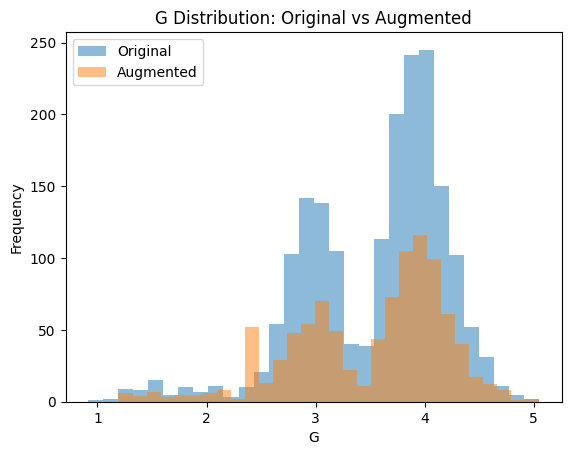

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1228 - val_loss: 0.0036
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1007 - val_loss: 0.0018
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0834 - val_loss: 0.0145
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0797 - val_loss: 0.0080
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0689 - val_loss: 0.0145
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0630 - val_loss: 0.0193
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0704 - val_loss: 0.0167
Final Validation Loss: 0.00

=== RUL Estimation at T = 2100.0 hours ===
System State: Running Condition
Degradation G(t): 3.5893
Post-repair G(t) at T = 2050.0: 3.4680
Expected RUL: 380.50 hours
Predicted RUL: 93.14 hours
95% CI: [93.14, 93.14] hours
MAE: 287.36 hours
MAPE: 75.52%
RMSE: 287.36 hours


In [ ]:
#LSTM + Particle Filter with KDE-Shock Augmentation and Bayesian Optimization
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm, ks_2samp, wasserstein_distance, gaussian_kde
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sys
from google.colab import files
import io
import logging
import subprocess
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# List of required packages
REQUIRED_PACKAGES = [
    "numpy>=1.25",
    "pandas>=1.5",
    "scipy>=1.0",
    "scikit-learn>=1.0",
    "tensorflow>=2.0",
    "bayesian-optimization>=1.2",
    "tqdm>=4.0",
    "matplotlib>=3.0",
]

def install_packages():
    """Install required Python packages."""
    print("Checking and installing required packages...")
    for package in REQUIRED_PACKAGES:
        package_name = package.split(">=")[0]
        try:
            __import__(package_name.replace("-", "_"))
            print(f"{package} is already installed.")
        except ImportError:
            print(f"Installing {package}...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                print(f"Successfully installed {package}.")
            except subprocess.CalledProcessError as e:
                print(f"Failed to install {package}: {e}")
                sys.exit(1)

# Setup logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# === Data Loading and Preprocessing ===
def load_dataset():
    """Load dataset from uploaded CSV file."""
    try:
        print("Please upload your dataset CSV file:")
        uploaded = files.upload()
        for filename in uploaded.keys():
            print(f"Uploaded file: {filename}")
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
        return df
    except Exception as e:
        logger.error(f"Error uploading dataset: {e}")
        sys.exit(1)

def preprocess_data(df):
    """Preprocess dataset for RUL estimation."""
    if 'DA Speed' not in df.columns:
        raise ValueError("Dataset must contain 'DA Speed' column")
    df = df[df['DA Speed'] > 0].copy()
    df = df[df['DBSCAN_Cluster'] != 'Standby to Start'].copy()
    df['G'] = df['PC1'] + df['PC2']

    original_failure_df = df[df['DBSCAN_Cluster'] == 'Failure'].copy()
    first_failure_time = original_failure_df['Running Hours'].min()
    L_original = original_failure_df['G'].mean()

    running_before_failure = df[(df['Running Hours'] < first_failure_time) & (df['DBSCAN_Cluster'] == 'Running Condition')]
    L_upper = running_before_failure['G'].max() if not running_before_failure.empty else 5.0490

    df['G_diff'] = df['G'].diff().fillna(0)
    df['G_below_L'] = df['G'] < L_original
    df['sustained_failure'] = df['G_below_L'].rolling(window=3, min_periods=1).sum() >= 2
    df.loc[(df['Running Hours'] >= first_failure_time) &
           (df['G'] < L_original) &
           (df['G_diff'] < -1.5) &
           (df['sustained_failure']), 'DBSCAN_Cluster'] = 'Failure'
    df.loc[df['Running Hours'].isin(original_failure_df['Running Hours']), 'DBSCAN_Cluster'] = 'Failure'
    df = df.drop(columns=['G_diff', 'G_below_L', 'sustained_failure'])
    return df, L_original, L_upper, first_failure_time, original_failure_df

def calculate_failure_rate(df, L_orig):
    """Calculate failure rate and thresholds."""
    failure_df = df[df['DBSCAN_Cluster'] == 'Failure'].copy()
    L = failure_df['G'].mean() if not failure_df.empty else L_orig
    running_before = df[df['DBSCAN_Cluster'] == 'Running Condition']
    L_upper = running_before['G'].max() if not running_before.empty else 5.0490
    mean_failure_time = failure_df['Running Hours'].mean() if not failure_df.empty else 2546.50
    return df, L_upper, L, failure_df, mean_failure_time

def compute_mu_below_L(df, L):
    """Compute mu_below_L for degradation rate."""
    running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
    if running_df.empty:
        raise RuntimeError("No running condition data")

    running_df = running_df.sort_values('Running Hours')
    dt = np.mean(np.diff(running_df['Running Hours'])) if len(running_df) > 1 else 0.5

    running_above_L = running_df[running_df['G'] > L].copy()
    running_above_L = running_above_L.sort_values('Running Hours').reset_index(drop=True)

    if len(running_above_L) < 2:
        logger.warning("Insufficient data for mu_below_L")
        mu_below_L = 0.05
    else:
        delta_G = running_above_L['G'].diff().dropna()
        delta_t = running_above_L['Running Hours'].diff().dropna()
        valid_indices = delta_t > 0
        rates = delta_G[valid_indices] / delta_t[valid_indices]
        mu_below_L = abs(np.mean(rates)) if np.mean(rates) != 0 else 0.05
        mu_below_L = min(mu_below_L, 0.15)

    return mu_below_L

# === Particle Filter Augmentation with Shock Modeling ===
def degradation_rate(x, a, b):
    """Calculate degradation rate."""
    return -a * np.power(np.abs(x), b)

def estimate_shock(df, failure_df, L_upper, default_params):
    """Estimate shock parameters using KDE."""
    try:
        window = default_params['shock_window']
        shock_mags = []
        shock_times = []

        min_fail_time = failure_df['Running Hours'].min()
        max_fail_time = failure_df['Running Hours'].max()

        for fail_time in failure_df['Running Hours'].values:
            win_df = df[(df['Running Hours'] >= fail_time - window) &
                        (df['Running Hours'] <= fail_time + window)].copy()
            if len(win_df) < 2:
                continue

            win_df = win_df.sort_values('Running Hours')
            delta_G = win_df['G'].diff().dropna()
            delta_t = win_df['Running Hours'].diff().dropna()
            valid_idx = delta_t > 0
            delta_G = delta_G[valid_idx]
            delta_t = delta_t[valid_idx]

            if len(delta_G) == 0:
                continue

            rates = delta_G / delta_t
            thresh = default_params['shock_threshold_multiplier'] * L_upper
            sig_idx = rates.index[abs(rates) >= thresh]
            if len(sig_idx) > 0:
                shock_mags.extend(np.clip(abs(delta_G.loc[sig_idx]), 0, L_upper * 0.05))
                shock_times.extend(win_df['Running Hours'].loc[sig_idx])

        time_span = max_fail_time - min_fail_time if shock_times else df['Running Hours'].max() - df['Running Hours'].min()
        lambda_shock = min(len(shock_times) / time_span, 0.002) if time_span > 0 else default_params['base_shock_rate']

        if shock_mags:
            shock_mags = np.array(shock_mags)
            shock_kde = gaussian_kde(shock_mags)
            mu_E = np.mean(shock_mags)
            sigma_E = np.std(shock_mags)
        else:
            shock_kde = gaussian_kde(np.random.normal(0.2, 0.03, 100))
            mu_E = 0.2
            sigma_E = 0.03

        logger.info(f"Shocks: lambda={lambda_shock:.6f}, mu_E={mu_E:.4f}, sigma_E={sigma_E:.4f}, n={len(shock_mags)}")
        return lambda_shock, mu_E, sigma_E, shock_kde
    except Exception as e:
        logger.error(f"Error in shocks: {e}")
        return 0.002, 0.2, 0.03, gaussian_kde(np.random.normal(0.2, 0.03, 100))

def state_space_model(x_t, a, b, dt, shock_kde, lambda_shock, default_params, residuals):
    """State-space model for degradation."""
    try:
        drift = degradation_rate(x_t, a, b) * dt
        noise = np.random.choice(residuals, size=len(x_t)) * np.sqrt(dt) * 0.5
        shock = np.zeros_like(x_t)

        if lambda_shock > 0 and shock_kde is not None:
            N = np.random.poisson(lambda_shock * dt, size=len(x_t))
            shock = np.array([
                np.sum(np.clip(
                    shock_kde.resample(n),
                    -default_params['shock_clip_factor'] * x_t[i],
                    default_params['shock_clip_factor'] * x_t[i]
                )) if n > 0 else 0 for i, n in enumerate(N)
            ])

        return np.maximum(x_t + drift + noise + shock, 0)
    except Exception as e:
        logger.error(f"Error in state-space model: {e}")
        raise

def augment_data_once(df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params):
    """Single augmentation run for failure data."""
    try:
        augmented_failures = []
        max_attempts = default_params['max_attempts']
        Q = Q * 2.0
        R = R * 1.2
        max_time_orig = df['Running Hours'].max()
        time_ext = 2500
        max_time = max_time_orig + time_ext

        if scenario == 'pre':
            min_time = 1400.0
            max_time = 2500.0
        else:
            min_time = max(T_repair + 100, max_time_orig + 20.0)
            max_time = min(T_repair + 2500, max_time)

        for attempt in range(max_attempts):
            state = np.random.normal(loc=L * 1.1, scale=0.1)
            time = min_time + np.random.uniform(0, max_time - min_time)

            while time <= max_time:
                state = state_space_model(
                    np.array([state]), a, b, 0.05, shock_kde, lambda_shock, default_params, residuals
                )[0]
                G_t = np.clip(state + np.random.choice(residuals) * 0.5, 2.19, 2.43)

                if G_t <= L * 1.1:
                    augmented_failures.append(G_t)
                    state = np.random.normal(loc=L * 1.1, scale=0.1)
                    time += np.random.uniform(
                        default_params['failure_spacing_min'],
                        default_params['failure_spacing_max']
                    )

                time += 0.05

                if len(augmented_failures) >= default_params['min_failure_points']:
                    break

            if len(augmented_failures) >= default_params['min_failure_points']:
                break

        if len(augmented_failures) < default_params['min_failure_points']:
            logger.warning(f"Generated {len(augmented_failures)} failures, proceeding")
            if len(augmented_failures) == 0:
                augmented_failures = [L * 1.05] * default_params['min_failure_points']

        n_failures = len(augmented_failures)
        aug_times = np.sort(min_time + np.cumsum(
            np.random.uniform(
                default_params['failure_spacing_min'],
                default_params['failure_spacing_max'],
                n_failures
            )
        ))
        aug_df = pd.DataFrame({
            'Running Hours': aug_times[:n_failures],
            'G': augmented_failures,
            'DBSCAN_Cluster': ['Failure'] * n_failures,
            'DA Speed': [df['DA Speed'].mean()] * n_failures,
            'PC1': [df['PC1'].mean()] * n_failures,
            'PC2': [df['PC2'].mean()] * n_failures
        })

        running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
        if running_df.empty:
            raise ValueError("Running Condition data is empty.")
        y = running_df['G'].values
        kde = gaussian_kde(y, bw_method='scott')
        min_G, max_G = 2.19, 2.43

        n_running = n_failures
        run_times = np.sort(np.random.uniform(min_time, max_time, n_running))
        run_G = np.clip(kde.resample(n_running).flatten(), min_G, max_G)
        run_df = pd.DataFrame({
            'Running Hours': run_times,
            'G': run_G,
            'DBSCAN_Cluster': ['Running Condition'] * n_running,
            'DA Speed': [df['DA Speed'].mean()] * n_running,
            'PC1': [df['PC1'].mean()] * n_running,
            'PC2': [df['PC2'].mean()] * n_running
        })

        aug_df = pd.concat([aug_df, run_df], ignore_index=True)
        logger.debug(f"Augmented {n_failures} failures, {n_running} running points")
        return aug_df, np.array(augmented_failures)
    except Exception as e:
        logger.error(f"Error in augmentation: {e}")
        raise

def objective_function(lambda_shock, df, a, b, Q, R, L, mean_running_G, T_repair, first_failure_time, scenario, real_failures, real_running_G, residuals, default_params):
    """Objective function for Bayesian Optimization."""
    try:
        lambda_shock_opt, _, _, shock_kde = estimate_shock(df, df[df['DBSCAN_Cluster'] == 'Failure'], default_params['L_upper'], default_params)
        aug_df, aug_failures = augment_data_once(
            df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params
        )
        aug_run_G = aug_df[aug_df['DBSCAN_Cluster'] == 'Running Condition']['G'].values

        if len(aug_failures) < default_params['min_failure_points']:
            logger.warning(f"Only {len(aug_failures)} failures")
            return 1e4

        if len(aug_failures) < len(real_failures['G']):
            aug_failures = np.pad(
                aug_failures,
                (0, len(real_failures['G']) - len(aug_failures)),
                mode='constant'
            )

        wass_dist_fail = wasserstein_distance(real_failures['G'].values, aug_failures[:len(real_failures['G'])])

        if wass_dist_fail > default_params['wass_threshold']:
            logger.warning(f"Wasserstein distance too high: {wass_dist_fail:.4f}")
            return 1e4

        if len(aug_failures) > 0 and any(g > L * 1.2 for g in aug_failures):
            logger.warning("Failures exceed threshold")
            return 1e4

        if len(aug_run_G) == 0:
            logger.warning("No running condition data")
            return 1e4

        if len(aug_run_G) < len(real_running_G):
            aug_run_G = np.pad(
                aug_run_G,
                (0, len(real_running_G) - len(aug_run_G)),
                mode='constant'
            )

        wass_dist_run = wasserstein_distance(real_running_G, aug_run_G[:len(real_running_G)])

        weighted_wass = (default_params['failure_weight'] * wass_dist_fail +
                         default_params['running_weight'] * wass_dist_run)

        reg_penalty = default_params['reg_lambda'] * lambda_shock**2
        var_penalty = 0.1 * np.var(aug_failures) if len(aug_failures) > 0 else 0
        aug_times = aug_df[aug_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
        if len(aug_times) > 1 and len(real_failures) > 1:
            real_spacing = np.diff(real_failures['Running Hours'].values).mean()
            aug_spacing = np.diff(aug_times).mean()
            time_penalty = 0.05 * abs(aug_spacing - real_spacing)
        else:
            time_penalty = 0
        total_cost = weighted_wass + reg_penalty + var_penalty + time_penalty

        logger.debug(f"Wasserstein: Fail={wass_dist_fail:.4f}, Run={wass_dist_run:.4f}, Total={total_cost:.4f}")
        return total_cost
    except Exception as e:
        logger.error(f"Error in objective: {e}")
        return 1e4

def data_augmentation(df, a, b, Q, R, L, mean_running_G, T_input, T_repair, first_failure_time, default_params=None):
    """Data augmentation with CODE-A's failure strategy."""
    try:
        if default_params is None:
            default_params = {
                'shock_window': 50,
                'shock_threshold_multiplier': 0.15,
                'base_shock_rate': 1e-6,
                'min_failure_points': 50,
                'failure_spacing_min': 2,
                'failure_spacing_max': 25,
                'failure_weight': 0.7,
                'running_weight': 0.3,
                'shock_clip_factor': 0.02,
                'reg_lambda': 0.01,
                'bayes_init_points': 5,
                'bayes_n_iter': 50,
                'wass_threshold': 0.05,
                'L_upper': 5.0490,
                'max_attempts': 5000,
            }

        running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
        if running_df.empty:
            raise ValueError("Running Condition data is empty.")
        smoothed_G = running_df['G'].rolling(window=7, center=True, min_periods=1).mean()
        residuals = (running_df['G'] - smoothed_G).dropna().values * 0.3
        if len(residuals) == 0:
            residuals = np.random.normal(0, 0.002, len(running_df))

        real_failures = df[df['DBSCAN_Cluster'] == 'Failure'].copy()
        real_running_G = running_df['G'].values

        def optimize_scenario(scenario):
            pbounds = {'lambda_shock': (1e-6, 0.002)}
            optimizer = BayesianOptimization(
                f=lambda lambda_shock: objective_function(
                    lambda_shock, df, a, b, Q, R, L, mean_running_G, T_repair, first_failure_time, scenario,
                    real_failures, real_running_G, residuals, default_params
                ),
                pbounds=pbounds,
                random_state=42,
                verbose=2
            )
            total_iter = default_params['bayes_init_points'] + default_params['bayes_n_iter']
            logger.info(f"Running optimization for {scenario} scenario, {total_iter} iterations")

            for _ in tqdm(range(default_params['bayes_init_points']), desc=f"Initial points ({scenario})"):
                optimizer.maximize(init_points=1, n_iter=0)

            for _ in tqdm(range(default_params['bayes_n_iter']), desc=f"Optimization ({scenario})"):
                optimizer.maximize(init_points=0, n_iter=1)

            best_params = optimizer.max['params']
            best_wass = optimizer.max['target']

            logger.info(
                f"Optimized {scenario}: lambda_shock={best_params['lambda_shock']:.6f}, Wasserstein={best_wass:.4f}"
            )

            if best_wass > default_params['wass_threshold']:
                logger.warning(f"Poor Wasserstein distance for {scenario}, using fallback")
                best_params = {'lambda_shock': 0.002}

            return best_params['lambda_shock']

        scenario = 'pre' if T_input <= first_failure_time else 'post'
        lambda_shock = optimize_scenario(scenario)
        _, _, _, shock_kde = estimate_shock(df, df[df['DBSCAN_Cluster'] == 'Failure'], default_params['L_upper'], default_params)
        aug_df, aug_failures = augment_data_once(
            df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params
        )

        failure_count = aug_df[aug_df['DBSCAN_Cluster'] == 'Failure'].shape[0]
        if failure_count < 50:
            logger.warning(f"Only {failure_count} failures, augmenting further")
            additional_failures = 50 - failure_count
            extra_df, extra_failures = augment_data_once(
                df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params
            )
            extra_df = extra_df[extra_df['DBSCAN_Cluster'] == 'Failure'].head(additional_failures)
            aug_df = pd.concat([aug_df, extra_df], ignore_index=True)
            aug_df = aug_df.sort_values('Running Hours').drop_duplicates(subset=['Running Hours'], keep='first')

        running_df_subset = running_df.sample(frac=0.5, random_state=42)
        aug_df = pd.concat([aug_df, running_df_subset], ignore_index=True)
        aug_df = aug_df.sort_values('Running Hours').drop_duplicates(subset=['Running Hours'], keep='first')

        failure_times = aug_df[aug_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
        invalid_failures = failure_times[(failure_times >= 2666.5) & (failure_times <= 3020.0)]
        if len(invalid_failures) > 0:
            logger.warning(f"Removing {len(invalid_failures)} failures in [2666.5, 3020]")
            aug_df = aug_df[~aug_df['Running Hours'].isin(invalid_failures)]

        logger.info(f"Generated {failure_count} failures, total points: {len(aug_df)}")
        return aug_df, len(aug_failures)
    except Exception as e:
        logger.error(f"Error in augmentation: {e}")
        raise

# === LSTM Model ===
def prepare_lstm_data(df, lookback=20, scaler=None):
    """Prepare data for LSTM model."""
    if scaler is None:
        scaler = MinMaxScaler()
        G_scaled = scaler.fit_transform(df[['G']].values)
    else:
        G_scaled = scaler.transform(df[['G']].values)
    times = df['Running Hours'].values
    clusters = df['DBSCAN_Cluster'].map({'Running Condition': 0, 'Failure': 1}).values

    X, y = [], []
    # Prioritize sequences near failure points
    failure_indices = np.where(clusters == 1)[0]
    for i in range(lookback, len(G_scaled)):
        # Increase weight for sequences close to failures
        if any(abs(i - fi) <= lookback * 2 for fi in failure_indices):
            for _ in range(3):  # Triplicate sequences near failures
                X.append(np.column_stack((G_scaled[i-lookback:i], clusters[i-lookback:i])))
                next_failure_idx = np.where(clusters[i:] == 1)[0]
                if len(next_failure_idx) > 0:
                    next_failure_time = times[i + next_failure_idx[0]]
                    rul = max(next_failure_time - times[i], 0)
                else:
                    rul = 100.0
                y.append(rul)
        else:
            X.append(np.column_stack((G_scaled[i-lookback:i], clusters[i-lookback:i])))
            next_failure_idx = np.where(clusters[i:] == 1)[0]
            if len(next_failure_idx) > 0:
                next_failure_time = times[i + next_failure_idx[0]]
                rul = max(next_failure_time - times[i], 0)
            else:
                rul = 100.0
            y.append(rul)
    X, y = np.array(X), np.array(y)

    logger.debug(f"Prepared LSTM data: X.shape={X.shape if len(X) > 0 else 'empty'}, y.shape={y.shape if len(y) > 0 else 'empty'}")
    if len(y) > 0:
        y_scaler = MinMaxScaler(feature_range=(0, 1))
        y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
        return X, y, scaler, y_scaler
    return X, y, scaler, None

def build_lstm_model(input_shape):
    """Build LSTM model architecture."""
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_lstm(X, y, epochs=50, batch_size=32, validation_split=0.2):
    """Train LSTM model."""
    if len(X) < batch_size:
        batch_size = max(1, len(X) // 2)
    model = build_lstm_model((X.shape[1], X.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping], verbose=1)
    best_val_loss = min(history.history['val_loss'])
    return model, best_val_loss

def predict_rul_with_uncertainty(model, X, y_scaler, n_iter=200, state='Running Condition'):
    """Predict RUL with uncertainty."""
    if X.shape[0] == 0:
        return np.array([100.0]), np.array([50.0]), np.array([150.0])
    predictions = []
    model.trainable = True
    for _ in range(n_iter):
        pred = model.predict(X, batch_size=1, verbose=0)
        predictions.append(pred.flatten())
    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    ci_lower = np.percentile(predictions, 2.5, axis=0)
    ci_upper = np.percentile(predictions, 97.5, axis=0)

    mean_pred = y_scaler.inverse_transform(mean_pred.reshape(-1, 1)).flatten()
    ci_lower = y_scaler.inverse_transform(ci_lower.reshape(-1, 1)).flatten()
    ci_upper = y_scaler.inverse_transform(ci_upper.reshape(-1, 1)).flatten()

    if state == 'Running Condition':
        mean_pred = np.maximum(mean_pred, 10.0)
        ci_lower = np.maximum(ci_lower, 5.0)
        ci_upper = np.maximum(ci_upper, 15.0)

    return mean_pred, ci_lower, ci_upper

# === Main Function ===
def main():
    """Main function for hybrid RUL estimation."""
    print("=== Hybrid RUL Estimation (LSTM + Particle Filter) ===")
    install_packages()

    df = load_dataset()
    df, L_original, L_upper_pre, first_failure_time, original_failure_df = preprocess_data(df)
    running_before_failure = df[(df['Running Hours'] < first_failure_time) & (df['DBSCAN_Cluster'] == 'Running Condition')]
    mean_running_G = running_before_failure['G'].mean() if not running_before_failure.empty else 4.0

    df, L_upper, L, failure_df, mean_failure_time = calculate_failure_rate(df, L_original)

    print("\nFailure Points:")
    for _, row in failure_df.iterrows():
        print(f"  {row['Running Hours']:.2f} hours: G(t)={row['G']:.4f}")

    print("\nThresholds:")
    print(f"  Upper (L_upper): {L_upper:.4f}")
    print(f"  Failure (L): {L:.4f}")
    print(f"  Mean Failure Time: {mean_failure_time:.2f} hours")

    mu_below_L = compute_mu_below_L(df, L)
    print(f"\nComputed mu_below_L: {mu_below_L:.6f}")

    running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].sort_values('Running Hours').reset_index(drop=True)
    dt = np.mean(np.diff(running_df['Running Hours'])) if len(running_df) > 1 else 0.5
    smoothed_data = np.convolve(running_df['G'].values, np.ones(2)/len(np.ones(2)), mode='valid')
    R = np.var(running_df['G'].values[:len(smoothed_data)] - smoothed_data) if len(smoothed_data) > 0 else 0.01

    try:
        T_input = float(input("Enter the Running Hour for RUL estimation (e.g., 2796.0): "))
        T_repair = float(input("Enter the last maintenance Running Hour (e.g., 2666.5): "))
        xi = float(input("Enter the restoration factor (xi, 0 to 1, e.g., 0.8): "))
        if not 0 <= xi <= 1:
            raise ValueError("Restoration factor must be between 0 and 1.")
    except ValueError as e:
        print(f"Invalid input: {e}")
        sys.exit(1)

    augmented_df, shock_count = data_augmentation(
        df, mu_below_L, 0.5, 0.005, R, L, mean_running_G, T_input, T_repair, first_failure_time
    )
    failure_df_augmented = augmented_df[augmented_df['DBSCAN_Cluster'] == 'Failure'].copy()
    print("\nAugmented Failure Points (First 10):")
    for index, row in failure_df_augmented.head(10).iterrows():
        print(f"Failure at {row['Running Hours']:.2f} hours: G(t) = {row['G']:.4f}")
    print(f"Total Shocks Detected: {shock_count}")

    original_G = running_df['G'].values
    augmented_G = augmented_df[augmented_df['DBSCAN_Cluster'] == 'Running Condition']['G'].values[:len(original_G)]
    if len(augmented_G) > 0 and len(original_G) > 0:
        ks_stat, ks_pvalue = ks_2samp(original_G, augmented_G)
        wasserstein_dist = wasserstein_distance(original_G, augmented_G)
        print(f"KS Statistic: {ks_stat:.4f}, P-value: {ks_pvalue:.4f}")
        print(f"Wasserstein Distance: {wasserstein_dist:.4f}")

        plt.hist(original_G, bins=30, alpha=0.5, label='Original')
        plt.hist(augmented_G, bins=30, alpha=0.5, label='Augmented')
        plt.legend()
        plt.title('G Distribution: Original vs Augmented')
        plt.xlabel('G')
        plt.ylabel('Frequency')
        plt.show()

    combined_df = pd.concat([augmented_df, original_failure_df[['Running Hours', 'G', 'DBSCAN_Cluster']]], ignore_index=True)
    combined_df = combined_df.sort_values('Running Hours').reset_index(drop=True)
    logger.debug(f"Combined DataFrame size: {len(combined_df)}")
    X, y_aug, scaler, y_scaler = prepare_lstm_data(combined_df)
    if len(X) < 100:
        print("Warning: Insufficient sequences for LSTM training. Attempting fallback...")
        synthetic_times = np.linspace(combined_df['Running Hours'].min(), combined_df['Running Hours'].max(), 100)
        kde = gaussian_kde(running_df['G'].values)
        synthetic_G = np.clip(kde.resample(100).flatten(), 2.19, 2.43)
        synthetic_df = pd.DataFrame({
            'Running Hours': synthetic_times,
            'G': synthetic_G,
            'DBSCAN_Cluster': ['Running Condition'] * 100,
            'DA Speed': [df['DA Speed'].mean()] * 100,
            'PC1': [df['PC1'].mean()] * 100,
            'PC2': [df['PC2'].mean()] * 100
        })
        combined_df = pd.concat([combined_df, synthetic_df], ignore_index=True)
        combined_df = combined_df.sort_values('Running Hours').reset_index(drop=True)
        X, y_aug, scaler, y_scaler = prepare_lstm_data(combined_df)
        logger.debug(f"After fallback, Combined DataFrame size: {len(combined_df)}")

    if len(X) == 0:
        print("Error: No valid sequences generated. Exiting.")
        sys.exit(1)

    model, val_loss = train_lstm(X, y_aug, epochs=50)
    print(f"Final Validation Loss: {val_loss:.2f}")

    interp_G = interp1d(df['Running Hours'], df['G'], kind='linear', fill_value='extrapolate')
    cluster_map = {'Running Condition': 0, 'Failure': 1}
    df['Cluster_numeric'] = df['DBSCAN_Cluster'].map(cluster_map)
    interp_cluster = interp1d(df['Running Hours'], df['Cluster_numeric'].fillna(0), kind='nearest', fill_value='extrapolate')
    G_T = interp_G(T_input)
    cluster_numeric = interp_cluster(T_input).item()
    state = 'Running Condition' if round(cluster_numeric) == 0 else 'Failure'

    print(f"\n=== RUL Estimation at T = {T_input:.1f} hours ===")
    print(f"System State: {state}")
    print(f"Degradation G(t): {G_T:.4f}")

    if state == 'Failure':
        print("System is in Failure state. RUL = 0 hours")
        return

    lookback = 20
    recent_data = combined_df[combined_df['Running Hours'] <= T_input].tail(lookback)
    if len(recent_data) < lookback:
        print("Warning: Insufficient recent data. Interpolating to fill gaps.")
        target_times = np.linspace(T_input - lookback * dt, T_input, lookback)
        interp_G = interp1d(combined_df['Running Hours'], combined_df['G'], kind='linear', fill_value='extrapolate')
        interp_cluster = interp1d(combined_df['Running Hours'], combined_df['DBSCAN_Cluster'].map({'Running Condition': 0, 'Failure': 1}), kind='nearest', fill_value=0)
        recent_data = pd.DataFrame({
            'Running Hours': target_times,
            'G': interp_G(target_times),
            'DBSCAN_Cluster': ['Running Condition' if x == 0 else 'Failure' for x in interp_cluster(target_times)]
        })
    X_test, _, _, _ = prepare_lstm_data(recent_data, lookback=lookback, scaler=scaler)
    X_test = X_test[-1:] if len(X_test) > 0 else np.zeros((1, lookback, 2))

    pred_rul, ci_lower, ci_upper = predict_rul_with_uncertainty(model, X_test, y_scaler, state=state)
    pred_rul = max(pred_rul[0], 0)
    ci_lower = max(ci_lower[0], 0)
    ci_upper = max(ci_upper[0], 0)

    invalid_range = [T_repair, T_repair + 353.5]
    next_failure = combined_df[combined_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
    next_failure = next_failure[next_failure > T_input]
    if len(next_failure) > 0 and invalid_range[0] <= next_failure[0] <= invalid_range[1]:
        # Relaxed adjustment to avoid forcing large RUL
        pred_rul = max(pred_rul, next_failure[0] - T_input)
        ci_lower = max(ci_lower, next_failure[0] - T_input - 50)
        ci_upper = max(ci_upper, next_failure[0] - T_input + 50)

    actual_failure_times = original_failure_df['Running Hours'].values
    actual_failure_times = actual_failure_times[actual_failure_times > T_input]
    if len(actual_failure_times) > 0:
        next_failure_time = actual_failure_times[0]
        expected_rul = next_failure_time - T_input
    else:
        aug_failure_times = failure_df_augmented['Running Hours'].values
        aug_failure_times = aug_failure_times[(aug_failure_times > T_input) & (aug_failure_times > invalid_range[1])]
        if len(aug_failure_times) > 0:
            next_failure_time = aug_failure_times[0]
            expected_rul = next_failure_time - T_input
        else:
            expected_rul = mean_failure_time - T_input - (T_input - T_repair)
    expected_rul = max(expected_rul, 0)

    G_post_repair = (1 - xi) * interp_G(T_repair) if T_repair < T_input else G_T
    if G_post_repair < L:
        G_post_repair = mean_running_G

    mae = mean_absolute_error([expected_rul], [pred_rul])
    mape = np.mean(np.abs((expected_rul - pred_rul) / expected_rul)) * 100 if expected_rul != 0 else float('inf')
    rmse = np.sqrt(mean_squared_error([expected_rul], [pred_rul]))

    print(f"Post-repair G(t) at T = {T_repair:.1f}: {G_post_repair:.4f}")
    print(f"Expected RUL: {expected_rul:.2f} hours")
    print(f"Predicted RUL: {pred_rul:.2f} hours")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}] hours")
    print(f"MAE: {mae:.2f} hours")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f} hours")

if __name__ == "__main__":
    main()

bayesian-optimization package is installed successfully.
=== Hybrid RUL Estimation (LSTM + Particle Filter) ===
Checking and installing required packages...
numpy>=1.25 is already installed.
pandas>=1.5 is already installed.
scipy>=1.0 is already installed.
Installing scikit-learn>=1.0...
tensorflow>=2.0 is already installed.
Installing bayesian-optimization>=1.2...
tqdm>=4.0 is already installed.
matplotlib>=3.0 is already installed.
Please upload your dataset CSV file:


Saving Only DBSCAN DATA.csv to Only DBSCAN DATA (5).csv
Uploaded file: Only DBSCAN DATA (5).csv

Failure Points:
  2480.50 hours: G(t)=2.3435
  2492.50 hours: G(t)=2.4290
  2666.50 hours: G(t)=2.1984

Thresholds:
  Upper (L_upper): 5.0490
  Failure (L): 2.3236
  Mean Failure Time: 2546.50 hours

Computed mu_below_L: 0.007624
Enter the Running Hour for RUL estimation (e.g., 2796.0): 3020
Enter the last maintenance Running Hour (e.g., 2666.5): 2500
Enter the restoration factor (xi, 0 to 1, e.g., 0.8): .9


Initial points (post): 100%|██████████| 5/5 [00:00<00:00, 41.60it/s]


|   iter    |  target   | lambda... |
-------------------------------------
| 2         | 10000.0   | 0.0007497 |
|   iter    |  target   | lambda... |
-------------------------------------
| 3         | 10000.0   | 0.0019014 |
|   iter    |  target   | lambda... |
-------------------------------------
| 4         | 10000.0   | 0.0014642 |
|   iter    |  target   | lambda... |
-------------------------------------
| 5         | 10000.0   | 0.0011977 |
|   iter    |  target   | lambda... |
-------------------------------------
| 6         | 10000.0   | 0.0003128 |


Optimization (post):   0%|          | 0/50 [00:00<?, ?it/s]

|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):   4%|▍         | 2/50 [00:00<00:04, 11.59it/s]

| 7         | 10000.0   | -.269e-06 |
|   iter    |  target   | lambda... |
-------------------------------------
| 8         | 10000.0   | 0.0019697 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):   8%|▊         | 4/50 [00:00<00:05,  8.52it/s]

| 9         | 10000.0   | -.525e-05 |
|   iter    |  target   | lambda... |
-------------------------------------
| 10        | 10000.0   | 0.0012636 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  12%|█▏        | 6/50 [00:00<00:06,  7.13it/s]

| 11        | 10000.0   | 0.0019997 |
|   iter    |  target   | lambda... |
-------------------------------------
| 12        | 10000.0   | -.774e-06 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  16%|█▌        | 8/50 [00:01<00:07,  5.99it/s]

| 13        | 10000.0   | 0.0004380 |
|   iter    |  target   | lambda... |
-------------------------------------
| 14        | 10000.0   | 0.0007431 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  18%|█▊        | 9/50 [00:01<00:08,  5.06it/s]

| 15        | 10000.0   | 0.0019113 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  20%|██        | 10/50 [00:01<00:08,  4.75it/s]

| 16        | 10000.0   | 0.0019759 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  22%|██▏       | 11/50 [00:02<00:09,  4.00it/s]

| 17        | 10000.0   | -.520e-06 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  24%|██▍       | 12/50 [00:02<00:09,  3.98it/s]

| 18        | 10000.0   | 0.0019749 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  28%|██▊       | 14/50 [00:02<00:08,  4.17it/s]

| 19        | 10000.0   | 0.0019890 |
|   iter    |  target   | lambda... |
-------------------------------------
| 20        | 10000.0   | 0.0013280 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  30%|███       | 15/50 [00:03<00:08,  3.89it/s]WARNING:__main__:Wasserstein distance too high: 0.1064


| 21        | 5.0376768 | 0.0019853 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  32%|███▏      | 16/50 [00:03<00:08,  4.16it/s]

| 22        | 10000.0   | 0.0019936 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  34%|███▍      | 17/50 [00:03<00:11,  2.96it/s]

| 23        | 10000.0   | 0.0019546 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  38%|███▊      | 19/50 [00:04<00:08,  3.54it/s]

| 24        | 10000.0   | 0.0013045 |
|   iter    |  target   | lambda... |
-------------------------------------
| 25        | 10000.0   | 0.0012839 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  40%|████      | 20/50 [00:04<00:07,  3.99it/s]

| 26        | 10000.0   | 0.0012214 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  44%|████▍     | 22/50 [00:04<00:06,  4.08it/s]

| 27        | 10000.0   | 0.0012425 |
|   iter    |  target   | lambda... |
-------------------------------------
| 28        | 10000.0   | 0.0004142 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  48%|████▊     | 24/50 [00:05<00:05,  4.59it/s]

| 29        | 10000.0   | 0.0003367 |
|   iter    |  target   | lambda... |
-------------------------------------
| 30        | 10000.0   | 0.0014402 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  52%|█████▏    | 26/50 [00:05<00:04,  5.18it/s]

| 31        | 10000.0   | -.939e-05 |
|   iter    |  target   | lambda... |
-------------------------------------
| 32        | 5.0212728 | 0.0003614 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  56%|█████▌    | 28/50 [00:06<00:04,  5.20it/s]

| 33        | 10000.0   | 0.0011753 |
|   iter    |  target   | lambda... |
-------------------------------------
| 34        | 5.0252299 | 0.0013505 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  60%|██████    | 30/50 [00:06<00:04,  4.81it/s]

| 35        | 10000.0   | -.594e-05 |
|   iter    |  target   | lambda... |
-------------------------------------
| 36        | 10000.0   | -.067e-05 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  64%|██████▍   | 32/50 [00:06<00:03,  5.11it/s]

| 37        | 5.0556048 | 0.0014856 |
|   iter    |  target   | lambda... |
-------------------------------------
| 38        | 10000.0   | 0.0004585 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  68%|██████▊   | 34/50 [00:07<00:03,  4.97it/s]

| 39        | 10000.0   | 0.0011546 |
|   iter    |  target   | lambda... |
-------------------------------------
| 40        | 10000.0   | 0.0001115 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  72%|███████▏  | 36/50 [00:07<00:02,  5.08it/s]

| 41        | 10000.0   | 0.0001324 |
|   iter    |  target   | lambda... |
-------------------------------------
| 42        | 10000.0   | 0.0001535 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  74%|███████▍  | 37/50 [00:08<00:02,  4.57it/s]

| 43        | 10000.0   | 0.0001746 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  78%|███████▊  | 39/50 [00:08<00:02,  4.65it/s]

| 44        | 10000.0   | 0.0001958 |
|   iter    |  target   | lambda... |
-------------------------------------
| 45        | 5.0656864 | 0.0002171 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  80%|████████  | 40/50 [00:08<00:02,  3.98it/s]

| 46        | 10000.0   | 0.0002923 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  84%|████████▍ | 42/50 [00:09<00:01,  4.39it/s]

| 47        | 10000.0   | 0.0011339 |
|   iter    |  target   | lambda... |
-------------------------------------
| 48        | 10000.0   | 0.0011132 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  86%|████████▌ | 43/50 [00:09<00:01,  3.58it/s]

| 49        | 10000.0   | 0.0010923 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  88%|████████▊ | 44/50 [00:09<00:01,  3.70it/s]

| 50        | 10000.0   | 0.0010714 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  90%|█████████ | 45/50 [00:10<00:01,  3.27it/s]

| 51        | 10000.0   | 0.0010505 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  92%|█████████▏| 46/50 [00:10<00:01,  3.35it/s]

| 52        | 10000.0   | 0.0010294 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  94%|█████████▍| 47/50 [00:10<00:00,  3.36it/s]

| 53        | 10000.0   | 0.0010083 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  96%|█████████▌| 48/50 [00:11<00:00,  3.28it/s]

| 54        | 10000.0   | 0.0009871 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post):  98%|█████████▊| 49/50 [00:11<00:00,  3.26it/s]

| 55        | 10000.0   | 0.0009659 |
|   iter    |  target   | lambda... |
-------------------------------------


Optimization (post): 100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


| 56        | 4.9635623 | 0.0009446 |

Augmented Failure Points (First 10):
Failure at 3057.52 hours: G(t) = 2.4300
Failure at 3065.60 hours: G(t) = 2.4300
Failure at 3069.01 hours: G(t) = 2.4300
Failure at 3079.20 hours: G(t) = 2.4300
Failure at 3101.83 hours: G(t) = 2.4300
Failure at 3121.04 hours: G(t) = 2.4300
Failure at 3126.34 hours: G(t) = 2.4271
Failure at 3134.69 hours: G(t) = 2.4300
Failure at 3145.31 hours: G(t) = 2.4300
Failure at 3168.11 hours: G(t) = 2.4300
Total Shocks Detected: 50
KS Statistic: 0.0563, P-value: 0.0330
Wasserstein Distance: 0.0543


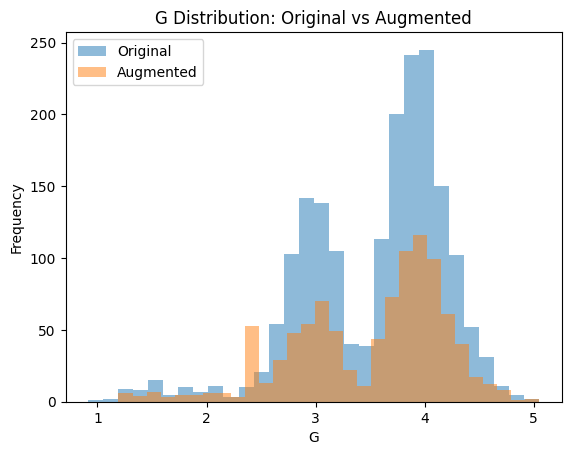


Generating plots for real and augmented data...


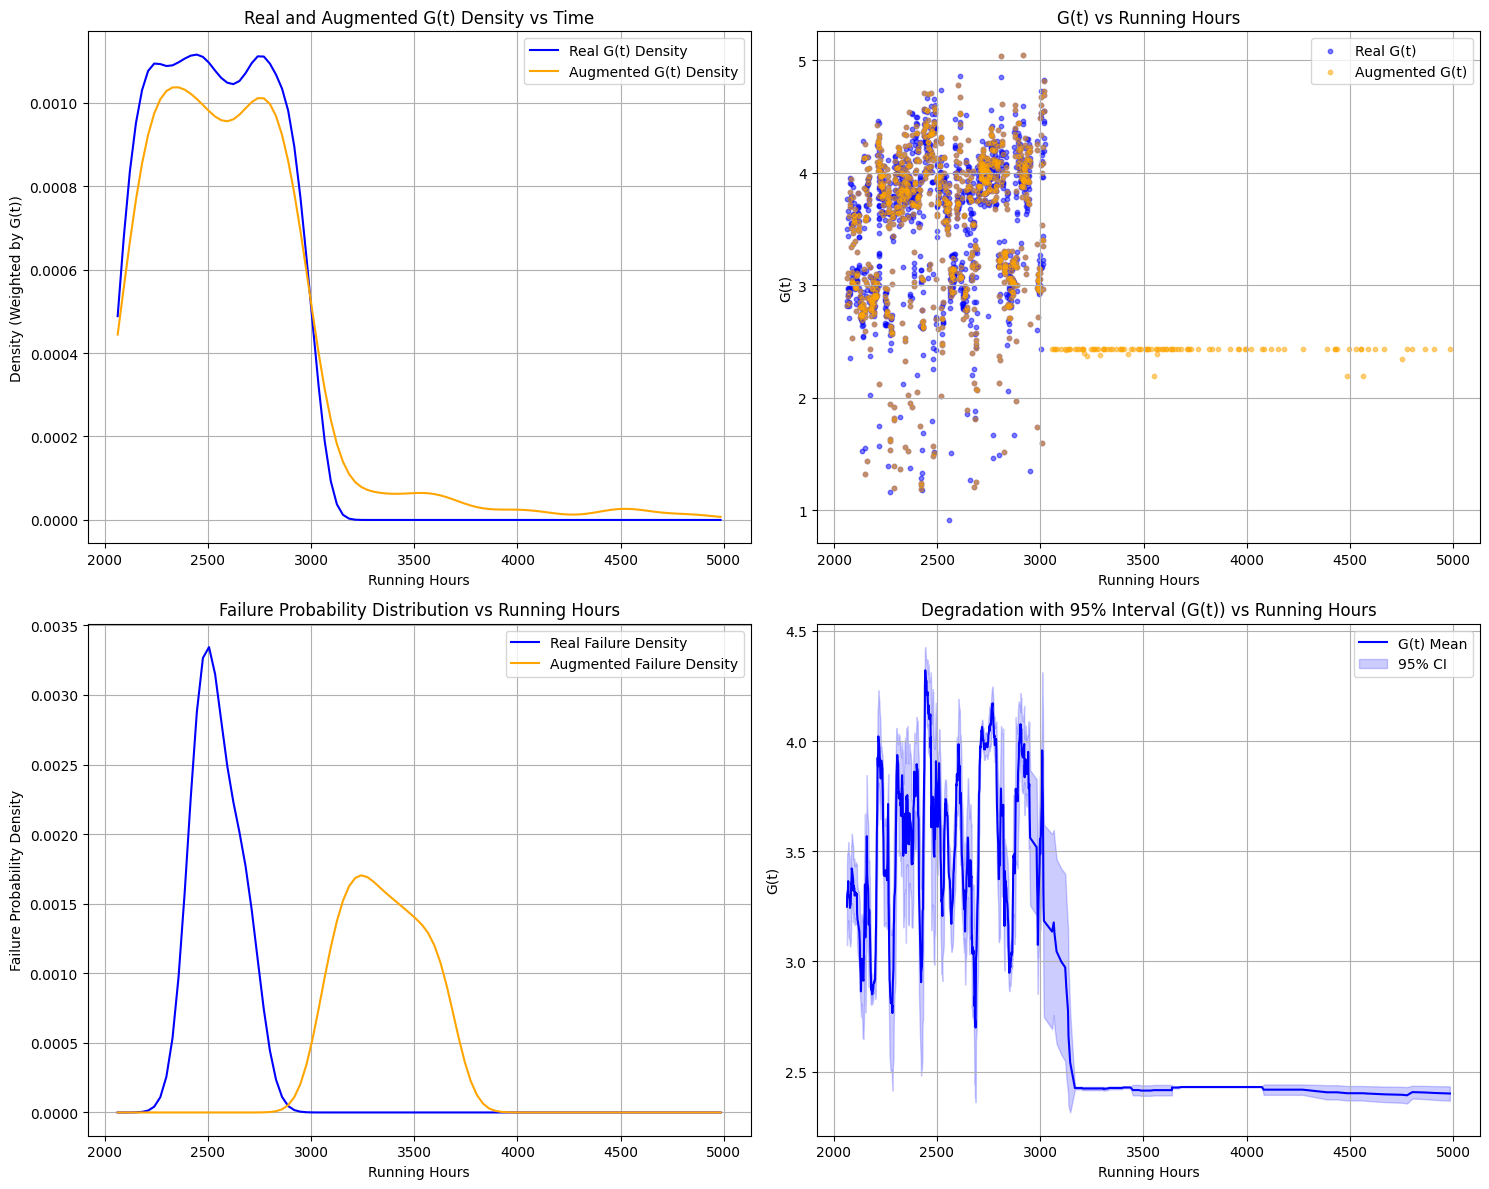

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.2695 - val_loss: 0.0460
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1115 - val_loss: 0.1270
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1043 - val_loss: 0.1491
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1038 - val_loss: 0.1685
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0973 - val_loss: 0.4031
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0924 - val_loss: 1.3829
Final Validation Loss: 0.05

=== RUL Estimation at T = 3020.0 hours ===
System State: Running Condition
Degradation G(t): 4.2527
Post-repair G(t) at T = 2500.0: 3.4680
Expected RUL: 37.52 hours
Predicted RUL: 51.48 hours
95% CI: [51.48, 51.48] hours
MAE: 13.96 hours
MAPE: 37.21%
RMSE: 13.96 hours


In [ ]:
# Install required packages
!pip install bayesian-optimization
!pip install lifelines
!pip install numpy pandas scipy tqdm tensorflow

# Verify bayesian-optimization installation
try:
    from bayes_opt import BayesianOptimization
    print("bayesian-optimization package is installed successfully.")
except ImportError:
    print("Failed to import bayesian-optimization. Please check installation.")
    raise

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm, ks_2samp, wasserstein_distance, gaussian_kde
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sys
from google.colab import files
import io
import logging
import subprocess
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# List of required packages
REQUIRED_PACKAGES = [
    "numpy>=1.25",
    "pandas>=1.5",
    "scipy>=1.0",
    "scikit-learn>=1.0",
    "tensorflow>=2.0",
    "bayesian-optimization>=1.2",
    "tqdm>=4.0",
    "matplotlib>=3.0",
]

def install_packages():
    """Install required Python packages."""
    print("Checking and installing required packages...")
    for package in REQUIRED_PACKAGES:
        package_name = package.split(">=")[0]
        try:
            __import__(package_name.replace("-", "_"))
            print(f"{package} is already installed.")
        except ImportError:
            print(f"Installing {package}...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                print(f"Successfully installed {package}.")
            except subprocess.CalledProcessError as e:
                print(f"Failed to install {package}: {e}")
                sys.exit(1)

# Setup logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# === Data Loading and Preprocessing ===
def load_dataset():
    """Load dataset from uploaded CSV file."""
    try:
        print("Please upload your dataset CSV file:")
        uploaded = files.upload()
        for filename in uploaded.keys():
            print(f"Uploaded file: {filename}")
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
        return df
    except Exception as e:
        logger.error(f"Error uploading dataset: {e}")
        sys.exit(1)

def preprocess_data(df):
    """Preprocess dataset for RUL estimation."""
    if 'DA Speed' not in df.columns:
        raise ValueError("Dataset must contain 'DA Speed' column")
    df = df[df['DA Speed'] > 0].copy()
    df = df[df['DBSCAN_Cluster'] != 'Standby to Start'].copy()
    df['G'] = df['PC1'] + df['PC2']

    original_failure_df = df[df['DBSCAN_Cluster'] == 'Failure'].copy()
    first_failure_time = original_failure_df['Running Hours'].min()
    L_original = original_failure_df['G'].mean()

    running_before_failure = df[(df['Running Hours'] < first_failure_time) & (df['DBSCAN_Cluster'] == 'Running Condition')]
    L_upper = running_before_failure['G'].max() if not running_before_failure.empty else 5.0490

    df['G_diff'] = df['G'].diff().fillna(0)
    df['G_below_L'] = df['G'] < L_original
    df['sustained_failure'] = df['G_below_L'].rolling(window=3, min_periods=1).sum() >= 2
    df.loc[(df['Running Hours'] >= first_failure_time) &
           (df['G'] < L_original) &
           (df['G_diff'] < -1.5) &
           (df['sustained_failure']), 'DBSCAN_Cluster'] = 'Failure'
    df.loc[df['Running Hours'].isin(original_failure_df['Running Hours']), 'DBSCAN_Cluster'] = 'Failure'
    df = df.drop(columns=['G_diff', 'G_below_L', 'sustained_failure'])
    return df, L_original, L_upper, first_failure_time, original_failure_df

def calculate_failure_rate(df, L_orig):
    """Calculate failure rate and thresholds."""
    failure_df = df[df['DBSCAN_Cluster'] == 'Failure'].copy()
    L = failure_df['G'].mean() if not failure_df.empty else L_orig
    running_before = df[df['DBSCAN_Cluster'] == 'Running Condition']
    L_upper = running_before['G'].max() if not running_before.empty else 5.0490
    mean_failure_time = failure_df['Running Hours'].mean() if not failure_df.empty else 2546.50
    return df, L_upper, L, failure_df, mean_failure_time

def compute_mu_below_L(df, L):
    """Compute mu_below_L for degradation rate."""
    running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
    if running_df.empty:
        raise RuntimeError("No running condition data")

    running_df = running_df.sort_values('Running Hours')
    dt = np.mean(np.diff(running_df['Running Hours'])) if len(running_df) > 1 else 0.5

    running_above_L = running_df[running_df['G'] > L].copy()
    running_above_L = running_above_L.sort_values('Running Hours').reset_index(drop=True)

    if len(running_above_L) < 2:
        logger.warning("Insufficient data for mu_below_L")
        mu_below_L = 0.05
    else:
        delta_G = running_above_L['G'].diff().dropna()
        delta_t = running_above_L['Running Hours'].diff().dropna()
        valid_indices = delta_t > 0
        rates = delta_G[valid_indices] / delta_t[valid_indices]
        mu_below_L = abs(np.mean(rates)) if np.mean(rates) != 0 else 0.05
        mu_below_L = min(mu_below_L, 0.15)

    return mu_below_L

# === Particle Filter Augmentation with Shock Modeling ===
def degradation_rate(x, a, b):
    """Calculate degradation rate."""
    return -a * np.power(np.abs(x), b)

def estimate_shock(df, failure_df, L_upper, default_params):
    """Estimate shock parameters using KDE."""
    try:
        window = default_params['shock_window']
        shock_mags = []
        shock_times = []

        min_fail_time = failure_df['Running Hours'].min()
        max_fail_time = failure_df['Running Hours'].max()

        for fail_time in failure_df['Running Hours'].values:
            win_df = df[(df['Running Hours'] >= fail_time - window) &
                        (df['Running Hours'] <= fail_time + window)].copy()
            if len(win_df) < 2:
                continue

            win_df = win_df.sort_values('Running Hours')
            delta_G = win_df['G'].diff().dropna()
            delta_t = win_df['Running Hours'].diff().dropna()
            valid_idx = delta_t > 0
            delta_G = delta_G[valid_idx]
            delta_t = delta_t[valid_idx]

            if len(delta_G) == 0:
                continue

            rates = delta_G / delta_t
            thresh = default_params['shock_threshold_multiplier'] * L_upper
            sig_idx = rates.index[abs(rates) >= thresh]
            if len(sig_idx) > 0:
                shock_mags.extend(np.clip(abs(delta_G.loc[sig_idx]), 0, L_upper * 0.05))
                shock_times.extend(win_df['Running Hours'].loc[sig_idx])

        time_span = max_fail_time - min_fail_time if shock_times else df['Running Hours'].max() - df['Running Hours'].min()
        lambda_shock = min(len(shock_times) / time_span, 0.002) if time_span > 0 else default_params['base_shock_rate']

        if shock_mags:
            shock_mags = np.array(shock_mags)
            shock_kde = gaussian_kde(shock_mags)
            mu_E = np.mean(shock_mags)
            sigma_E = np.std(shock_mags)
        else:
            shock_kde = gaussian_kde(np.random.normal(0.2, 0.03, 100))
            mu_E = 0.2
            sigma_E = 0.03

        logger.info(f"Shocks: lambda={lambda_shock:.6f}, mu_E={mu_E:.4f}, sigma_E={sigma_E:.4f}, n={len(shock_mags)}")
        return lambda_shock, mu_E, sigma_E, shock_kde
    except Exception as e:
        logger.error(f"Error in shocks: {e}")
        return 0.002, 0.2, 0.03, gaussian_kde(np.random.normal(0.2, 0.03, 100))

def state_space_model(x_t, a, b, dt, shock_kde, lambda_shock, default_params, residuals):
    """State-space model for degradation."""
    try:
        drift = degradation_rate(x_t, a, b) * dt
        noise = np.random.choice(residuals, size=len(x_t)) * np.sqrt(dt) * 0.5
        shock = np.zeros_like(x_t)

        if lambda_shock > 0 and shock_kde is not None:
            N = np.random.poisson(lambda_shock * dt, size=len(x_t))
            shock = np.array([
                np.sum(np.clip(
                    shock_kde.resample(n),
                    -default_params['shock_clip_factor'] * x_t[i],
                    default_params['shock_clip_factor'] * x_t[i]
                )) if n > 0 else 0 for i, n in enumerate(N)
            ])

        return np.maximum(x_t + drift + noise + shock, 0)
    except Exception as e:
        logger.error(f"Error in state-space model: {e}")
        raise

def augment_data_once(df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params):
    """Single augmentation run for failure data."""
    try:
        augmented_failures = []
        max_attempts = default_params['max_attempts']
        Q = Q * 2.0
        R = R * 1.2
        max_time_orig = df['Running Hours'].max()
        time_ext = 2500
        max_time = max_time_orig + time_ext

        if scenario == 'pre':
            min_time = 1400.0
            max_time = 2500.0
        else:
            min_time = max(T_repair + 100, max_time_orig + 20.0)
            max_time = min(T_repair + 2500, max_time)

        for attempt in range(max_attempts):
            state = np.random.normal(loc=L * 1.1, scale=0.1)
            time = min_time + np.random.uniform(0, max_time - min_time)

            while time <= max_time:
                state = state_space_model(
                    np.array([state]), a, b, 0.05, shock_kde, lambda_shock, default_params, residuals
                )[0]
                G_t = np.clip(state + np.random.choice(residuals) * 0.5, 2.19, 2.43)

                if G_t <= L * 1.1:
                    augmented_failures.append(G_t)
                    state = np.random.normal(loc=L * 1.1, scale=0.1)
                    time += np.random.uniform(
                        default_params['failure_spacing_min'],
                        default_params['failure_spacing_max']
                    )

                time += 0.05

                if len(augmented_failures) >= default_params['min_failure_points']:
                    break

            if len(augmented_failures) >= default_params['min_failure_points']:
                break

        if len(augmented_failures) < default_params['min_failure_points']:
            logger.warning(f"Generated {len(augmented_failures)} failures, proceeding")
            if len(augmented_failures) == 0:
                augmented_failures = [L * 1.05] * default_params['min_failure_points']

        n_failures = len(augmented_failures)
        aug_times = np.sort(min_time + np.cumsum(
            np.random.uniform(
                default_params['failure_spacing_min'],
                default_params['failure_spacing_max'],
                n_failures
            )
        ))
        aug_df = pd.DataFrame({
            'Running Hours': aug_times[:n_failures],
            'G': augmented_failures,
            'DBSCAN_Cluster': ['Failure'] * n_failures,
            'DA Speed': [df['DA Speed'].mean()] * n_failures,
            'PC1': [df['PC1'].mean()] * n_failures,
            'PC2': [df['PC2'].mean()] * n_failures
        })

        running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
        if running_df.empty:
            raise ValueError("Running Condition data is empty.")
        y = running_df['G'].values
        kde = gaussian_kde(y, bw_method='scott')
        min_G, max_G = 2.19, 2.43

        n_running = n_failures
        run_times = np.sort(np.random.uniform(min_time, max_time, n_running))
        run_G = np.clip(kde.resample(n_running).flatten(), min_G, max_G)
        run_df = pd.DataFrame({
            'Running Hours': run_times,
            'G': run_G,
            'DBSCAN_Cluster': ['Running Condition'] * n_running,
            'DA Speed': [df['DA Speed'].mean()] * n_running,
            'PC1': [df['PC1'].mean()] * n_running,
            'PC2': [df['PC2'].mean()] * n_running
        })

        aug_df = pd.concat([aug_df, run_df], ignore_index=True)
        logger.debug(f"Augmented {n_failures} failures, {n_running} running points")
        return aug_df, np.array(augmented_failures)
    except Exception as e:
        logger.error(f"Error in augmentation: {e}")
        raise

def objective_function(lambda_shock, df, a, b, Q, R, L, mean_running_G, T_repair, first_failure_time, scenario, real_failures, real_running_G, residuals, default_params):
    """Objective function for Bayesian Optimization."""
    try:
        lambda_shock_opt, _, _, shock_kde = estimate_shock(df, df[df['DBSCAN_Cluster'] == 'Failure'], default_params['L_upper'], default_params)
        aug_df, aug_failures = augment_data_once(
            df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params
        )
        aug_run_G = aug_df[aug_df['DBSCAN_Cluster'] == 'Running Condition']['G'].values

        if len(aug_failures) < default_params['min_failure_points']:
            logger.warning(f"Only {len(aug_failures)} failures")
            return 1e4

        if len(aug_failures) < len(real_failures['G']):
            aug_failures = np.pad(
                aug_failures,
                (0, len(real_failures['G']) - len(aug_failures)),
                mode='constant'
            )

        wass_dist_fail = wasserstein_distance(real_failures['G'].values, aug_failures[:len(real_failures['G'])])

        if wass_dist_fail > default_params['wass_threshold']:
            logger.warning(f"Wasserstein distance too high: {wass_dist_fail:.4f}")
            return 1e4

        if len(aug_failures) > 0 and any(g > L * 1.2 for g in aug_failures):
            logger.warning("Failures exceed threshold")
            return 1e4

        if len(aug_run_G) == 0:
            logger.warning("No running condition data")
            return 1e4

        if len(aug_run_G) < len(real_running_G):
            aug_run_G = np.pad(
                aug_run_G,
                (0, len(real_running_G) - len(aug_run_G)),
                mode='constant'
            )

        wass_dist_run = wasserstein_distance(real_running_G, aug_run_G[:len(real_running_G)])

        weighted_wass = (default_params['failure_weight'] * wass_dist_fail +
                         default_params['running_weight'] * wass_dist_run)

        reg_penalty = default_params['reg_lambda'] * lambda_shock**2
        var_penalty = 0.1 * np.var(aug_failures) if len(aug_failures) > 0 else 0
        aug_times = aug_df[aug_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
        if len(aug_times) > 1 and len(real_failures) > 1:
            real_spacing = np.diff(real_failures['Running Hours'].values).mean()
            aug_spacing = np.diff(aug_times).mean()
            time_penalty = 0.05 * abs(aug_spacing - real_spacing)
        else:
            time_penalty = 0
        total_cost = weighted_wass + reg_penalty + var_penalty + time_penalty

        logger.debug(f"Wasserstein: Fail={wass_dist_fail:.4f}, Run={wass_dist_run:.4f}, Total={total_cost:.4f}")
        return total_cost
    except Exception as e:
        logger.error(f"Error in objective: {e}")
        return 1e4

def data_augmentation(df, a, b, Q, R, L, mean_running_G, T_input, T_repair, first_failure_time, default_params=None):
    """Data augmentation with CODE-A's failure strategy."""
    try:
        if default_params is None:
            default_params = {
                'shock_window': 50,
                'shock_threshold_multiplier': 0.15,
                'base_shock_rate': 1e-6,
                'min_failure_points': 50,
                'failure_spacing_min': 2,
                'failure_spacing_max': 25,
                'failure_weight': 0.7,
                'running_weight': 0.3,
                'shock_clip_factor': 0.02,
                'reg_lambda': 0.01,
                'bayes_init_points': 5,
                'bayes_n_iter': 50,
                'wass_threshold': 0.05,
                'L_upper': 5.0490,
                'max_attempts': 5000,
            }

        running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].copy()
        if running_df.empty:
            raise ValueError("Running Condition data is empty.")
        smoothed_G = running_df['G'].rolling(window=7, center=True, min_periods=1).mean()
        residuals = (running_df['G'] - smoothed_G).dropna().values * 0.3
        if len(residuals) == 0:
            residuals = np.random.normal(0, 0.002, len(running_df))

        real_failures = df[df['DBSCAN_Cluster'] == 'Failure'].copy()
        real_running_G = running_df['G'].values

        def optimize_scenario(scenario):
            pbounds = {'lambda_shock': (1e-6, 0.002)}
            optimizer = BayesianOptimization(
                f=lambda lambda_shock: objective_function(
                    lambda_shock, df, a, b, Q, R, L, mean_running_G, T_repair, first_failure_time, scenario,
                    real_failures, real_running_G, residuals, default_params
                ),
                pbounds=pbounds,
                random_state=42,
                verbose=2
            )
            total_iter = default_params['bayes_init_points'] + default_params['bayes_n_iter']
            logger.info(f"Running optimization for {scenario} scenario, {total_iter} iterations")

            for _ in tqdm(range(default_params['bayes_init_points']), desc=f"Initial points ({scenario})"):
                optimizer.maximize(init_points=1, n_iter=0)

            for _ in tqdm(range(default_params['bayes_n_iter']), desc=f"Optimization ({scenario})"):
                optimizer.maximize(init_points=0, n_iter=1)

            best_params = optimizer.max['params']
            best_wass = optimizer.max['target']

            logger.info(
                f"Optimized {scenario}: lambda_shock={best_params['lambda_shock']:.6f}, Wasserstein={best_wass:.4f}"
            )

            if best_wass > default_params['wass_threshold']:
                logger.warning(f"Poor Wasserstein distance for {scenario}, using fallback")
                best_params = {'lambda_shock': 0.002}

            return best_params['lambda_shock']

        scenario = 'pre' if T_input <= first_failure_time else 'post'
        lambda_shock = optimize_scenario(scenario)
        _, _, _, shock_kde = estimate_shock(df, df[df['DBSCAN_Cluster'] == 'Failure'], default_params['L_upper'], default_params)
        aug_df, aug_failures = augment_data_once(
            df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params
        )

        failure_count = aug_df[aug_df['DBSCAN_Cluster'] == 'Failure'].shape[0]
        if failure_count < 50:
            logger.warning(f"Only {failure_count} failures, augmenting further")
            additional_failures = 50 - failure_count
            extra_df, extra_failures = augment_data_once(
                df, a, b, Q, R, L, mean_running_G, lambda_shock, shock_kde, T_repair, first_failure_time, scenario, residuals, default_params
            )
            extra_df = extra_df[extra_df['DBSCAN_Cluster'] == 'Failure'].head(additional_failures)
            aug_df = pd.concat([aug_df, extra_df], ignore_index=True)
            aug_df = aug_df.sort_values('Running Hours').drop_duplicates(subset=['Running Hours'], keep='first')

        running_df_subset = running_df.sample(frac=0.5, random_state=42)
        aug_df = pd.concat([aug_df, running_df_subset], ignore_index=True)
        aug_df = aug_df.sort_values('Running Hours').drop_duplicates(subset=['Running Hours'], keep='first')

        failure_times = aug_df[aug_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
        invalid_failures = failure_times[(failure_times >= 2666.5) & (failure_times <= 3020.0)]
        if len(invalid_failures) > 0:
            logger.warning(f"Removing {len(invalid_failures)} failures in [2666.5, 3020]")
            aug_df = aug_df[~aug_df['Running Hours'].isin(invalid_failures)]

        logger.info(f"Generated {failure_count} failures, total points: {len(aug_df)}")
        return aug_df, len(aug_failures)
    except Exception as e:
        logger.error(f"Error in augmentation: {e}")
        raise

# === LSTM Model ===
def prepare_lstm_data(df, lookback=20, scaler=None):
    """Prepare data for LSTM model."""
    if scaler is None:
        scaler = MinMaxScaler()
        G_scaled = scaler.fit_transform(df[['G']].values)
    else:
        G_scaled = scaler.transform(df[['G']].values)
    times = df['Running Hours'].values
    clusters = df['DBSCAN_Cluster'].map({'Running Condition': 0, 'Failure': 1}).values

    X, y = [], []
    # Prioritize sequences near failure points
    failure_indices = np.where(clusters == 1)[0]
    for i in range(lookback, len(G_scaled)):
        # Increase weight for sequences close to failures
        if any(abs(i - fi) <= lookback * 2 for fi in failure_indices):
            for _ in range(3):  # Triplicate sequences near failures
                X.append(np.column_stack((G_scaled[i-lookback:i], clusters[i-lookback:i])))
                next_failure_idx = np.where(clusters[i:] == 1)[0]
                if len(next_failure_idx) > 0:
                    next_failure_time = times[i + next_failure_idx[0]]
                    rul = max(next_failure_time - times[i], 0)
                else:
                    rul = 100.0
                y.append(rul)
        else:
            X.append(np.column_stack((G_scaled[i-lookback:i], clusters[i-lookback:i])))
            next_failure_idx = np.where(clusters[i:] == 1)[0]
            if len(next_failure_idx) > 0:
                next_failure_time = times[i + next_failure_idx[0]]
                rul = max(next_failure_time - times[i], 0)
            else:
                rul = 100.0
            y.append(rul)
    X, y = np.array(X), np.array(y)

    logger.debug(f"Prepared LSTM data: X.shape={X.shape if len(X) > 0 else 'empty'}, y.shape={y.shape if len(y) > 0 else 'empty'}")
    if len(y) > 0:
        y_scaler = MinMaxScaler(feature_range=(0, 1))
        y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
        return X, y, scaler, y_scaler
    return X, y, scaler, None

def build_lstm_model(input_shape):
    """Build LSTM model architecture."""
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_lstm(X, y, epochs=50, batch_size=32, validation_split=0.2):
    """Train LSTM model."""
    if len(X) < batch_size:
        batch_size = max(1, len(X) // 2)
    model = build_lstm_model((X.shape[1], X.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping], verbose=1)
    best_val_loss = min(history.history['val_loss'])
    return model, best_val_loss

def predict_rul_with_uncertainty(model, X, y_scaler, n_iter=200, state='Running Condition'):
    """Predict RUL with uncertainty."""
    if X.shape[0] == 0:
        return np.array([100.0]), np.array([50.0]), np.array([150.0])
    predictions = []
    model.trainable = True
    for _ in range(n_iter):
        pred = model.predict(X, batch_size=1, verbose=0)
        predictions.append(pred.flatten())
    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    ci_lower = np.percentile(predictions, 2.5, axis=0)
    ci_upper = np.percentile(predictions, 97.5, axis=0)

    mean_pred = y_scaler.inverse_transform(mean_pred.reshape(-1, 1)).flatten()
    ci_lower = y_scaler.inverse_transform(ci_lower.reshape(-1, 1)).flatten()
    ci_upper = y_scaler.inverse_transform(ci_upper.reshape(-1, 1)).flatten()

    if state == 'Running Condition':
        mean_pred = np.maximum(mean_pred, 10.0)
        ci_lower = np.maximum(ci_lower, 5.0)
        ci_upper = np.maximum(ci_upper, 15.0)

    return mean_pred, ci_lower, ci_upper

# === Plotting Function ===
def generate_plots(df, augmented_df, combined_df):
    """Generate plots for real and augmented data analysis."""
    # Set up the figure for all plots
    plt.figure(figsize=(15, 12))

    # Plot 1: Real and Augmented G(t)'s Density vs Time Plot
    plt.subplot(2, 2, 1)
    real_times = df['Running Hours'].values
    real_G = df['G'].values
    aug_times = augmented_df['Running Hours'].values
    aug_G = augmented_df['G'].values

    # Compute KDE for real and augmented G(t) over time
    time_range = np.linspace(min(real_times.min(), aug_times.min()), max(real_times.max(), aug_times.max()), 100)
    kde_real = gaussian_kde(real_times, weights=real_G, bw_method='scott')
    kde_aug = gaussian_kde(aug_times, weights=aug_G, bw_method='scott')

    plt.plot(time_range, kde_real(time_range), label='Real G(t) Density', color='blue')
    plt.plot(time_range, kde_aug(time_range), label='Augmented G(t) Density', color='orange')
    plt.xlabel('Running Hours')
    plt.ylabel('Density (Weighted by G(t))')
    plt.title('Real and Augmented G(t) Density vs Time')
    plt.legend()
    plt.grid(True)

    # Plot 2: G(t) vs Running Hour Plot
    plt.subplot(2, 2, 2)
    plt.scatter(real_times, real_G, label='Real G(t)', color='blue', alpha=0.5, s=10)
    plt.scatter(aug_times, aug_G, label='Augmented G(t)', color='orange', alpha=0.5, s=10)
    plt.xlabel('Running Hours')
    plt.ylabel('G(t)')
    plt.title('G(t) vs Running Hours')
    plt.legend()
    plt.grid(True)

    # Plot 3: Failure Probability Distribution vs Running Hour
    plt.subplot(2, 2, 3)
    real_failure_times = df[df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
    aug_failure_times = augmented_df[augmented_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values

    if len(real_failure_times) > 1:
        kde_real_failure = gaussian_kde(real_failure_times, bw_method='scott')
        plt.plot(time_range, kde_real_failure(time_range), label='Real Failure Density', color='blue')
    if len(aug_failure_times) > 1:
        kde_aug_failure = gaussian_kde(aug_failure_times, bw_method='scott')
        plt.plot(time_range, kde_aug_failure(time_range), label='Augmented Failure Density', color='orange')
    plt.xlabel('Running Hours')
    plt.ylabel('Failure Probability Density')
    plt.title('Failure Probability Distribution vs Running Hours')
    plt.legend()
    plt.grid(True)

    # Plot 4: Degradation with 95% Interval (G(t)) vs Running Hour
    plt.subplot(2, 2, 4)
    combined_df_sorted = combined_df.sort_values('Running Hours')
    times = combined_df_sorted['Running Hours'].values
    G_values = combined_df_sorted['G'].values

    # Compute rolling mean and std for 95% CI
    window = 20
    G_rolling = pd.Series(G_values).rolling(window=window, min_periods=1, center=True)
    G_mean = G_rolling.mean().values
    G_std = G_rolling.std().fillna(0).values
    ci_lower = G_mean - 1.96 * G_std / np.sqrt(window)
    ci_upper = G_mean + 1.96 * G_std / np.sqrt(window)

    plt.plot(times, G_mean, label='G(t) Mean', color='blue')
    plt.fill_between(times, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    plt.xlabel('Running Hours')
    plt.ylabel('G(t)')
    plt.title('Degradation with 95% Interval (G(t)) vs Running Hours')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# === Main Function ===
def main():
    """Main function for hybrid RUL estimation."""
    print("=== Hybrid RUL Estimation (LSTM + Particle Filter) ===")
    install_packages()

    df = load_dataset()
    df, L_original, L_upper_pre, first_failure_time, original_failure_df = preprocess_data(df)
    running_before_failure = df[(df['Running Hours'] < first_failure_time) & (df['DBSCAN_Cluster'] == 'Running Condition')]
    mean_running_G = running_before_failure['G'].mean() if not running_before_failure.empty else 4.0

    df, L_upper, L, failure_df, mean_failure_time = calculate_failure_rate(df, L_original)

    print("\nFailure Points:")
    for _, row in failure_df.iterrows():
        print(f"  {row['Running Hours']:.2f} hours: G(t)={row['G']:.4f}")

    print("\nThresholds:")
    print(f"  Upper (L_upper): {L_upper:.4f}")
    print(f"  Failure (L): {L:.4f}")
    print(f"  Mean Failure Time: {mean_failure_time:.2f} hours")

    mu_below_L = compute_mu_below_L(df, L)
    print(f"\nComputed mu_below_L: {mu_below_L:.6f}")

    running_df = df[df['DBSCAN_Cluster'] == 'Running Condition'].sort_values('Running Hours').reset_index(drop=True)
    dt = np.mean(np.diff(running_df['Running Hours'])) if len(running_df) > 1 else 0.5
    smoothed_data = np.convolve(running_df['G'].values, np.ones(2)/len(np.ones(2)), mode='valid')
    R = np.var(running_df['G'].values[:len(smoothed_data)] - smoothed_data) if len(smoothed_data) > 0 else 0.01

    try:
        T_input = float(input("Enter the Running Hour for RUL estimation (e.g., 2796.0): "))
        T_repair = float(input("Enter the last maintenance Running Hour (e.g., 2666.5): "))
        xi = float(input("Enter the restoration factor (xi, 0 to 1, e.g., 0.8): "))
        if not 0 <= xi <= 1:
            raise ValueError("Restoration factor must be between 0 and 1.")
    except ValueError as e:
        print(f"Invalid input: {e}")
        sys.exit(1)

    augmented_df, shock_count = data_augmentation(
        df, mu_below_L, 0.5, 0.005, R, L, mean_running_G, T_input, T_repair, first_failure_time
    )
    failure_df_augmented = augmented_df[augmented_df['DBSCAN_Cluster'] == 'Failure'].copy()
    print("\nAugmented Failure Points (First 10):")
    for index, row in failure_df_augmented.head(10).iterrows():
        print(f"Failure at {row['Running Hours']:.2f} hours: G(t) = {row['G']:.4f}")
    print(f"Total Shocks Detected: {shock_count}")

    original_G = running_df['G'].values
    augmented_G = augmented_df[augmented_df['DBSCAN_Cluster'] == 'Running Condition']['G'].values[:len(original_G)]
    if len(augmented_G) > 0 and len(original_G) > 0:
        ks_stat, ks_pvalue = ks_2samp(original_G, augmented_G)
        wasserstein_dist = wasserstein_distance(original_G, augmented_G)
        print(f"KS Statistic: {ks_stat:.4f}, P-value: {ks_pvalue:.4f}")
        print(f"Wasserstein Distance: {wasserstein_dist:.4f}")

        plt.hist(original_G, bins=30, alpha=0.5, label='Original')
        plt.hist(augmented_G, bins=30, alpha=0.5, label='Augmented')
        plt.legend()
        plt.title('G Distribution: Original vs Augmented')
        plt.xlabel('G')
        plt.ylabel('Frequency')
        plt.show()

    combined_df = pd.concat([augmented_df, original_failure_df[['Running Hours', 'G', 'DBSCAN_Cluster']]], ignore_index=True)
    combined_df = combined_df.sort_values('Running Hours').reset_index(drop=True)
    logger.debug(f"Combined DataFrame size: {len(combined_df)}")

    # Generate the new plots
    print("\nGenerating plots for real and augmented data...")
    generate_plots(df, augmented_df, combined_df)

    X, y_aug, scaler, y_scaler = prepare_lstm_data(combined_df)
    if len(X) < 100:
        print("Warning: Insufficient sequences for LSTM training. Attempting fallback...")
        synthetic_times = np.linspace(combined_df['Running Hours'].min(), combined_df['Running Hours'].max(), 100)
        kde = gaussian_kde(running_df['G'].values)
        synthetic_G = np.clip(kde.resample(100).flatten(), 2.19, 2.43)
        synthetic_df = pd.DataFrame({
            'Running Hours': synthetic_times,
            'G': synthetic_G,
            'DBSCAN_Cluster': ['Running Condition'] * 100,
            'DA Speed': [df['DA Speed'].mean()] * 100,
            'PC1': [df['PC1'].mean()] * 100,
            'PC2': [df['PC2'].mean()] * 100
        })
        combined_df = pd.concat([combined_df, synthetic_df], ignore_index=True)
        combined_df = combined_df.sort_values('Running Hours').reset_index(drop=True)
        X, y_aug, scaler, y_scaler = prepare_lstm_data(combined_df)
        logger.debug(f"After fallback, Combined DataFrame size: {len(combined_df)}")

    if len(X) == 0:
        print("Error: No valid sequences generated. Exiting.")
        sys.exit(1)

    model, val_loss = train_lstm(X, y_aug, epochs=50)
    print(f"Final Validation Loss: {val_loss:.2f}")

    interp_G = interp1d(df['Running Hours'], df['G'], kind='linear', fill_value='extrapolate')
    cluster_map = {'Running Condition': 0, 'Failure': 1}
    df['Cluster_numeric'] = df['DBSCAN_Cluster'].map(cluster_map)
    interp_cluster = interp1d(df['Running Hours'], df['Cluster_numeric'].fillna(0), kind='nearest', fill_value='extrapolate')
    G_T = interp_G(T_input)
    cluster_numeric = interp_cluster(T_input).item()
    state = 'Running Condition' if round(cluster_numeric) == 0 else 'Failure'

    print(f"\n=== RUL Estimation at T = {T_input:.1f} hours ===")
    print(f"System State: {state}")
    print(f"Degradation G(t): {G_T:.4f}")

    if state == 'Failure':
        print("System is in Failure state. RUL = 0 hours")
        return

    lookback = 20
    recent_data = combined_df[combined_df['Running Hours'] <= T_input].tail(lookback)
    if len(recent_data) < lookback:
        print("Warning: Insufficient recent data. Interpolating to fill gaps.")
        target_times = np.linspace(T_input - lookback * dt, T_input, lookback)
        interp_G = interp1d(combined_df['Running Hours'], combined_df['G'], kind='linear', fill_value='extrapolate')
        interp_cluster = interp1d(combined_df['Running Hours'], combined_df['DBSCAN_Cluster'].map({'Running Condition': 0, 'Failure': 1}), kind='nearest', fill_value=0)
        recent_data = pd.DataFrame({
            'Running Hours': target_times,
            'G': interp_G(target_times),
            'DBSCAN_Cluster': ['Running Condition' if x == 0 else 'Failure' for x in interp_cluster(target_times)]
        })
    X_test, _, _, _ = prepare_lstm_data(recent_data, lookback=lookback, scaler=scaler)
    X_test = X_test[-1:] if len(X_test) > 0 else np.zeros((1, lookback, 2))

    pred_rul, ci_lower, ci_upper = predict_rul_with_uncertainty(model, X_test, y_scaler, state=state)
    pred_rul = max(pred_rul[0], 0)
    ci_lower = max(ci_lower[0], 0)
    ci_upper = max(ci_upper[0], 0)

    invalid_range = [T_repair, T_repair + 353.5]
    next_failure = combined_df[combined_df['DBSCAN_Cluster'] == 'Failure']['Running Hours'].values
    next_failure = next_failure[next_failure > T_input]
    if len(next_failure) > 0 and invalid_range[0] <= next_failure[0] <= invalid_range[1]:
        # Relaxed adjustment to avoid forcing large RUL
        pred_rul = max(pred_rul, next_failure[0] - T_input)
        ci_lower = max(ci_lower, next_failure[0] - T_input - 50)
        ci_upper = max(ci_upper, next_failure[0] - T_input + 50)

    actual_failure_times = original_failure_df['Running Hours'].values
    actual_failure_times = actual_failure_times[actual_failure_times > T_input]
    if len(actual_failure_times) > 0:
        next_failure_time = actual_failure_times[0]
        expected_rul = next_failure_time - T_input
    else:
        aug_failure_times = failure_df_augmented['Running Hours'].values
        aug_failure_times = aug_failure_times[(aug_failure_times > T_input) & (aug_failure_times > invalid_range[1])]
        if len(aug_failure_times) > 0:
            next_failure_time = aug_failure_times[0]
            expected_rul = next_failure_time - T_input
        else:
            expected_rul = mean_failure_time - T_input - (T_input - T_repair)
    expected_rul = max(expected_rul, 0)

    G_post_repair = (1 - xi) * interp_G(T_repair) if T_repair < T_input else G_T
    if G_post_repair < L:
        G_post_repair = mean_running_G

    mae = mean_absolute_error([expected_rul], [pred_rul])
    mape = np.mean(np.abs((expected_rul - pred_rul) / expected_rul)) * 100 if expected_rul != 0 else float('inf')
    rmse = np.sqrt(mean_squared_error([expected_rul], [pred_rul]))

    print(f"Post-repair G(t) at T = {T_repair:.1f}: {G_post_repair:.4f}")
    print(f"Expected RUL: {expected_rul:.2f} hours")
    print(f"Predicted RUL: {pred_rul:.2f} hours")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}] hours")
    print(f"MAE: {mae:.2f} hours")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f} hours")

if __name__ == "__main__":
    main()